# Deep Learning - Assigment 1

### Group Number: 22

### Teammates:
1. **Mahshid Jafar Tajrishi**
2. **Bar Melinarskiy**
3. **Cis van Aken**
4. **Simon van Klompenburg**

## Imports entire notebook

In [1]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 13.5 MB/s eta 0:00:00


In [2]:
# Importing libraries
import pandas as pd
import numpy as np
from scipy.io import loadmat
from IPython.display import display
import torch
import torch.nn as nn
import torch.optim as optim
import optuna
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchsummary import summary
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
torch.autograd.set_detect_anomaly(True)
from copy import deepcopy as dc
import random
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [3]:
from google.colab import files
mat_data = files.upload()

Saving Xtrain.mat to Xtrain.mat


## Global Definitions

In [4]:
# Path to the zip file
data_dir = "./Data"
data_path = "Xtrain.mat"

# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set pandas display options to show all columns
pd.set_option('display.max_columns', None)

# Set a professional style for the plots
sns.set_theme(style="whitegrid")

In [5]:
# Check if CUDA is available
print(torch.__version__)
print(torch.version.cuda)  # Should match CUDA 12.5
print(torch.backends.cudnn.version())  # Should return a version, not None
print(torch.cuda.is_available())  # Should return True

2.6.0+cu124
12.4
90300
True


### Utilities

In [6]:
def create_sequences(data, window_size, forecast_steps=1):
    X, y = [], []
    for i in range(len(data) - window_size - forecast_steps + 1):
        X.append(data[i:i + window_size, 0])
        y.append(data[i + window_size:i + window_size + forecast_steps, 0])
    X = np.array(X).reshape(-1, window_size, 1)
    y = np.array(y).reshape(-1, forecast_steps)
    return X, y

def prepare_dataloader(series, window_size, batch_size=16):
    """
    Preprocess the datasets for the transformer model.

    Args:
        series: Array of numbers with the sequence of the laser measurements.
        window_size: Integer, the sliding window size.
        batch_size: The number of samples used in one forward and backward pass through the network.

    Returns:
        DataLoader, X, y
    """
    X, y = create_sequences(series, window_size)
    # Ensure proper shapes: X → (N, seq_len, input_dim), y → (N, input_dim)
    X_tensor = torch.tensor(X, dtype=torch.float32)  # Shape: (N, seq_len, input_dim)
    y_tensor = torch.tensor(y, dtype=torch.float32)  # Shape: (N, input_dim)
    dataset = TensorDataset(X_tensor, y_tensor)
    return DataLoader(dataset, batch_size=batch_size, shuffle=False), X_tensor, y_tensor

def train_model(model, train_loader, val_loader, attempt_index, epochs=20, lr=1e-3, teacher_forcing_prob=0.5, patience=10):
    """
    Train the given model with validation and return the final validation L1 loss.
    Includes early stopping based on validation loss.
    Logs all metrics (L1, MSE, MAE) for each epoch into a DataFrame.
    """
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
    # Define loss functions
    huberLoss_criterion = nn.HuberLoss()  # Huber Loss
    mse_criterion = nn.MSELoss()  # MSE Loss
    mae_criterion = nn.L1Loss()  # MAE Loss (same as L1 Loss)

    best_val_loss = float('inf')
    best_model_state = model.state_dict()  # Initialize with the current model state
    no_improvement_epochs = 0  # Counter for early stopping

    # DataFrame to store metrics
    metrics_df = pd.DataFrame(columns=["trial_id", "epoch", "train_l1", "train_mse", "train_mae", "val_l1", "val_mse", "val_mae"])

    # Progress bar for epochs
    epochs_pbar = tqdm(range(epochs), desc=f"Trial: {attempt_index}", unit="epoch")

    for epoch in epochs_pbar:
        # Training phase
        model.train()
        running_train_huberLoss_loss = 0.0
        running_train_mse_loss = 0.0
        running_train_mae_loss = 0.0

        for batch_index, batch in enumerate(train_loader):
            x_batch, y_batch = batch[0].to(device), batch[1].to(device)

            # Forward pass
            output = model(x_batch)

            # Apply teacher forcing
            if random.random() < teacher_forcing_prob:
                x_batch = x_batch.clone()  # Avoid in-place modification
                x_batch[:, -1, 0] = y_batch[:, 0]

            # Calculate loss
            huberLoss_loss = huberLoss_criterion(output, y_batch)
            mse_loss = mse_criterion(output, y_batch)
            mae_loss = mae_criterion(output, y_batch)

            running_train_huberLoss_loss += huberLoss_loss.item()
            running_train_mse_loss += mse_loss.item()
            running_train_mae_loss += mae_loss.item()

            # Backward pass
            optimizer.zero_grad()
            mae_loss.backward()
            optimizer.step()

        avg_train_huberLoss_loss = running_train_huberLoss_loss / len(train_loader)
        avg_train_mse_loss = running_train_mse_loss / len(train_loader)
        avg_train_mae_loss = running_train_mae_loss / len(train_loader)

        # Validation phase
        model.eval()
        running_val_huberLoss_loss = 0.0
        running_val_mse_loss = 0.0
        running_val_mae_loss = 0.0

        with torch.no_grad():
            for batch in val_loader:
                x_batch, y_batch = batch[0].to(device), batch[1].to(device)
                output = model(x_batch)

                huberLoss_loss = huberLoss_criterion(output, y_batch)
                mse_loss = mse_criterion(output, y_batch)
                mae_loss = mae_criterion(output, y_batch)

                running_val_huberLoss_loss += huberLoss_loss.item()
                running_val_mse_loss += mse_loss.item()
                running_val_mae_loss += mae_loss.item()

        avg_val_huberLoss_loss = running_val_huberLoss_loss / len(val_loader)
        avg_val_mse_loss = running_val_mse_loss / len(val_loader)
        avg_val_mae_loss = running_val_mae_loss / len(val_loader)

        # Save metrics to DataFrame
        new_row = pd.DataFrame([{
            "trial_id": attempt_index,
            "epoch": epoch + 1,
            "train_HuberLoss": avg_train_huberLoss_loss,
            "train_MSE": avg_train_mse_loss,
            "train_MAE": avg_train_mae_loss,
            "val_HuberLoss": avg_val_huberLoss_loss,
            "val_MSE": avg_val_mse_loss,
            "val_MAE": avg_val_mae_loss
        }])
        metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

        # Save the best model
        if avg_val_mae_loss < best_val_loss:
            best_val_loss = avg_val_mae_loss
            best_model_state = model.state_dict()
            no_improvement_epochs = 0  # Reset early stopping counter
        else:
            no_improvement_epochs += 1  # Increment early stopping counter

        # Early stopping
        if no_improvement_epochs >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            break

        # Adjust learning rate
        scheduler.step()

        # Update progress bar
        epochs_pbar.set_postfix(
            Train_huberLoss_Loss=avg_train_huberLoss_loss,
            Train_MSE_Loss=avg_train_mse_loss,
            Train_MAE_Loss=avg_train_mae_loss,
            Val_huberLoss_Loss=avg_val_huberLoss_loss,
            Val_MSE_Loss=avg_val_mse_loss,
            Val_MAE_Loss=avg_val_mae_loss,
        )

    # Load the best model
    model.load_state_dict(best_model_state)

    return best_val_loss, metrics_df  # Return the best validation L1 loss and metrics DataFrame

### Gated Recurrent Unit (GRU) RNN Model

In [7]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers, dropout):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        self.dropout = dropout

        self.gru = nn.GRU(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)
        self.dropout = nn.Dropout(dropout)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(x.device)

        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out


### Load and Split the dataset into train-validation

In [12]:
# Define augmentation functions
def add_noise(x, std=0.05):
    return x + np.random.normal(0, std, size=x.shape)

def add_drift(x, strength=0.05):
    drift = np.linspace(0, strength, num=len(x)).reshape(-1, 1)
    return x + drift

def time_warp(x, stretch_factor=1.15):
    original_steps = np.arange(len(x))
    new_steps = np.linspace(0, len(x) - 1, int(len(x) * stretch_factor))
    warped = interp1d(original_steps, x.ravel(), kind='linear', fill_value="extrapolate")(new_steps)
    warped = warped[:len(x)]  # clip/pad to original size
    return warped.reshape(-1, 1)

# Define jittering function
def add_jitter(x, std=0.01):
    """
    Add small random perturbations (jitter) to the data.

    Args:
        x (np.ndarray): Input data.
        std (float): Standard deviation of the jitter.

    Returns:
        np.ndarray: Jittered data.
    """
    return x + np.random.normal(0, std, size=x.shape)

data = loadmat(data_path)
measurements = data['Xtrain']
# Check the shape of the data
print("Shape of measurements:", measurements.shape)

# Display the first few rows of the data
print(f"First 5 measurements: {measurements[:5]}")

print(f"measurements range: min={measurements.min()}, max={measurements.max()}")

# Creating sequences
max_window_size = 50  # Maximum window size
# Split data into training and validation sets
size_of_test = 200 + max_window_size  # 200 steps for testing + window size
train_data, val_data = measurements[:-size_of_test], measurements[-size_of_test:]

# Normalize the training data
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data)

# Normalize the validation data using the same scaler
val_data_normalized = scaler.transform(val_data)

# Augment training data
print(f"Train shape before augmention: {train_data.shape}")

augmented = [train_data]  # 1x original

for _ in range(2):  # 2x noise
    augmented.append(add_noise(train_data))

# for _ in range(2):  # 2x drift
#     augmented.append(add_drift(train_data))

# for _ in range(2):  # 2x time warp
#     augmented.append(time_warp(train_data))

for _ in range(2):  # 2x jittering
    augmented.append(add_jitter(train_data))

train_augmented = np.vstack(augmented)
print("Augmented shape:", train_augmented.shape)

# Creating sequences
train_dataset, val_dataset = train_data, val_data_normalized

print(f"Train shape: {train_dataset.shape}, Val shape: {val_dataset.shape}")
print(f"train_dataset range: min={train_dataset.min()}, max={train_dataset.max()}")
print(f"val_dataset range: min={val_dataset.min()}, max={val_dataset.max()}")

Shape of measurements: (1000, 1)
First 5 measurements: [[ 86]
 [141]
 [ 95]
 [ 41]
 [ 22]]
measurements range: min=2, max=255
Train shape before augmention: (750, 1)
Augmented shape: (3750, 1)
Train shape: (750, 1), Val shape: (250, 1)
train_dataset range: min=2, max=255
val_dataset range: min=-0.9209486166007904, max=0.3992094861660078


### Training the Model

In [13]:
best_model = None

# Initialize a global DataFrame to store metrics for all trials
all_metrics_df = pd.DataFrame(columns=["trial_id", "epoch", "train_HuberLoss", "train_MSE", "train_MAE", "val_HuberLoss", "val_MSE", "val_MAE",
                                       "hidden_size", "num_layers", "learning_rate", "batch_size", "window_size", "dropout"])

def objective(trial):
    global all_metrics_df  # Use the global DataFrame to store metrics

    # Suggest hyperparameters
    hidden_size = trial.suggest_int('hidden_size', 32, 256, step=32)
    num_layers = trial.suggest_int('num_layers', 1, 3)
    learning_rate = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    window_size = trial.suggest_int('window_size', 5, 75, step=3)
    dropout = trial.suggest_float('dropout', 1e-1, 3e-1, log=True)

    # Update data loaders with the suggested batch size
    train_loader, train_X, train_y = prepare_dataloader(train_dataset, window_size, batch_size=batch_size)
    val_loader, val_X, val_y = prepare_dataloader(val_dataset, window_size, batch_size=batch_size)

    # Define the model
    model = GRU(
        input_size=1,  # Number of features in the input sequence
        hidden_size=hidden_size,
        num_stacked_layers=num_layers,
        dropout=dropout
    ).to(device)

    # Train the model and get the final validation loss and metrics DataFrame
    trial_index = trial.number + 1  # Start from 1 for better readability in logs
    val_loss, metrics_df = train_model(
        model, train_loader, val_loader, attempt_index=trial_index, epochs=100, lr=learning_rate
    )

    # Add trial parameters to the metrics DataFrame
    metrics_df["hidden_size"] = hidden_size
    metrics_df["num_layers"] = num_layers
    metrics_df["learning_rate"] = learning_rate
    metrics_df["batch_size"] = batch_size
    metrics_df["window_size"] = window_size
    metrics_df["dropout"] = dropout

    # Save the best model
    if trial.number == 0 or val_loss < study.best_value:
        torch.save(model.state_dict(), "best_model.pth")
        print(f"Best model saved with trial {trial.number}")
        best_model = model

        # Save the best hyperparameters
        with open("best_hyperparameters.json", "w") as f:
            json.dump({
                "hidden_size": hidden_size,
                "num_layers": num_layers,
                "learning_rate": learning_rate,
                "batch_size": batch_size,
                "window_size": window_size,
                "dropout": dropout
            }, f)

    # Append the metrics for this trial to the global DataFrame
    all_metrics_df = pd.concat([all_metrics_df, metrics_df], ignore_index=True)

    return val_loss  # Optuna will minimize this


# Create a study object
study = optuna.create_study(direction="minimize")  # Minimize validation loss

# Optimize the objective function
study.optimize(objective, n_trials=250)  # Run 100 trials

# Save the combined metrics DataFrame to a CSV file
all_metrics_df.to_csv("all_trials_metrics.csv", index=False)
print("All metrics saved to all_trials_metrics.csv")

# Print the best hyperparameters
print("Best hyperparameters:", study.best_params)

# Print the best validation loss
print("Best validation loss:", study.best_value)

# Load the best model
best_model = GRU(
    input_size=1,
    hidden_size=study.best_params['hidden_size'],
    num_stacked_layers=study.best_params['num_layers'],
    dropout = study.best_params['dropout']
).to(device)
best_model.load_state_dict(torch.load("best_model.pth"))
print("Best model loaded.")

# Update train_loader and val_loader with the best hyperparameters
train_loader, train_X, train_y = prepare_dataloader(train_dataset, study.best_params['window_size'], batch_size=study.best_params['batch_size'])
val_loader, val_X, val_y = prepare_dataloader(val_dataset, study.best_params['window_size'], batch_size=study.best_params['batch_size'])
print("Data loaders updated with best hyperparameters.")

[I 2025-05-07 11:03:13,980] A new study created in memory with name: no-name-34904b9f-02a2-4634-baa1-5bb37c64dc77
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 1:   0%|          | 0/100 [00:00<?, ?epoch/s]

<ipython-input-13-7b36d353bc21>:62: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_metrics_df = pd.concat([all_metrics_df, metrics_df], ignore_index=True)
[I 2025-05-07 11:03:23,799] Trial 0 finished with value: 17.743338176182338 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.00230977566699912, 'batch_size': 32, 'window_size': 50, 'dropout': 0.11874749033799367}. Best is trial 0 with value: 17.743338176182338.


Early stopping triggered after 11 epochs.
Best model saved with trial 0


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 2:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:03:25,537] Trial 1 finished with value: 17.6153507232666 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.004414472512678391, 'batch_size': 64, 'window_size': 44, 'dropout': 0.11294219986785294}. Best is trial 1 with value: 17.6153507232666.


Early stopping triggered after 11 epochs.
Best model saved with trial 1


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 3:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:03:27,718] Trial 2 finished with value: 1.3003136962652206 and parameters: {'hidden_size': 32, 'num_layers': 2, 'lr': 0.004681134627983708, 'batch_size': 32, 'window_size': 14, 'dropout': 0.1087379105808608}. Best is trial 2 with value: 1.3003136962652206.


Early stopping triggered after 11 epochs.
Best model saved with trial 2


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 4:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:03:30,056] Trial 3 finished with value: 0.7286307641438076 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 0.0006707957364994157, 'batch_size': 32, 'window_size': 56, 'dropout': 0.10476754733420066}. Best is trial 3 with value: 0.7286307641438076.


Early stopping triggered after 11 epochs.
Best model saved with trial 3


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 5:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:03:34,226] Trial 4 finished with value: 0.3619597256183624 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 0.00020368677054010185, 'batch_size': 64, 'window_size': 62, 'dropout': 0.23790359563031255}. Best is trial 4 with value: 0.3619597256183624.


Early stopping triggered after 29 epochs.
Best model saved with trial 4


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 6:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:03:36,403] Trial 5 finished with value: 0.327682226896286 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 0.0006055703869217248, 'batch_size': 64, 'window_size': 56, 'dropout': 0.24203093120796848}. Best is trial 5 with value: 0.327682226896286.


Early stopping triggered after 14 epochs.
Best model saved with trial 5


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 7:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:03:39,032] Trial 6 finished with value: 0.6945453211665154 and parameters: {'hidden_size': 128, 'num_layers': 3, 'lr': 0.0001717845002480643, 'batch_size': 32, 'window_size': 5, 'dropout': 0.12611072869469186}. Best is trial 5 with value: 0.327682226896286.


Early stopping triggered after 11 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 8:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:03:41,127] Trial 7 finished with value: 0.38893114030361176 and parameters: {'hidden_size': 32, 'num_layers': 2, 'lr': 0.00029902368873341534, 'batch_size': 32, 'window_size': 59, 'dropout': 0.1477374502907088}. Best is trial 5 with value: 0.327682226896286.


Early stopping triggered after 11 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 9:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:03:42,681] Trial 8 finished with value: 0.5878203809261322 and parameters: {'hidden_size': 128, 'num_layers': 3, 'lr': 0.0001080791757579125, 'batch_size': 64, 'window_size': 44, 'dropout': 0.2030033750614908}. Best is trial 5 with value: 0.327682226896286.


Early stopping triggered after 11 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 10:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:03:45,695] Trial 9 finished with value: 0.7717179581522942 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 0.0009276835492740443, 'batch_size': 32, 'window_size': 5, 'dropout': 0.24423240004223584}. Best is trial 5 with value: 0.327682226896286.


Early stopping triggered after 11 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 11:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:03:54,535] Trial 10 finished with value: 0.549369752407074 and parameters: {'hidden_size': 192, 'num_layers': 1, 'lr': 1.4957900196754344e-05, 'batch_size': 128, 'window_size': 29, 'dropout': 0.29675882488095817}. Best is trial 5 with value: 0.327682226896286.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 12:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:04:06,712] Trial 11 finished with value: 0.33108725150426227 and parameters: {'hidden_size': 192, 'num_layers': 1, 'lr': 4.970231054826085e-05, 'batch_size': 64, 'window_size': 74, 'dropout': 0.20358752907391417}. Best is trial 5 with value: 0.327682226896286.


Early stopping triggered after 77 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 13:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:04:22,437] Trial 12 finished with value: 0.32506035765012103 and parameters: {'hidden_size': 192, 'num_layers': 1, 'lr': 3.287092424039924e-05, 'batch_size': 64, 'window_size': 71, 'dropout': 0.17944104206724196}. Best is trial 12 with value: 0.32506035765012103.


Best model saved with trial 12


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 14:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:04:33,391] Trial 13 finished with value: 0.595208744208018 and parameters: {'hidden_size': 192, 'num_layers': 1, 'lr': 1.6025652476021068e-05, 'batch_size': 64, 'window_size': 74, 'dropout': 0.16208487248414588}. Best is trial 12 with value: 0.32506035765012103.


Early stopping triggered after 71 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 15:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:04:39,246] Trial 14 finished with value: 0.5360848009586334 and parameters: {'hidden_size': 64, 'num_layers': 1, 'lr': 4.7795305464617514e-05, 'batch_size': 128, 'window_size': 65, 'dropout': 0.19114211597465758}. Best is trial 12 with value: 0.32506035765012103.


Early stopping triggered after 87 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 16:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:04:41,991] Trial 15 finished with value: 3.1576810479164124 and parameters: {'hidden_size': 224, 'num_layers': 3, 'lr': 0.0010215087535302807, 'batch_size': 64, 'window_size': 32, 'dropout': 0.2516407107596938}. Best is trial 12 with value: 0.32506035765012103.


Early stopping triggered after 11 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 17:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:04:54,620] Trial 16 finished with value: 0.3358478049437205 and parameters: {'hidden_size': 160, 'num_layers': 1, 'lr': 5.744881995636184e-05, 'batch_size': 64, 'window_size': 68, 'dropout': 0.14758859815341757}. Best is trial 12 with value: 0.32506035765012103.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 18:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:04:55,726] Trial 17 finished with value: 0.5844132825732231 and parameters: {'hidden_size': 96, 'num_layers': 1, 'lr': 0.0006786687474708829, 'batch_size': 64, 'window_size': 53, 'dropout': 0.29824157903771725}. Best is trial 12 with value: 0.32506035765012103.


Early stopping triggered after 11 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 19:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:04:56,891] Trial 18 finished with value: 0.3950488418340683 and parameters: {'hidden_size': 160, 'num_layers': 3, 'lr': 0.0019145376857712911, 'batch_size': 128, 'window_size': 35, 'dropout': 0.17700852101829545}. Best is trial 12 with value: 0.32506035765012103.


Early stopping triggered after 11 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 20:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:05:10,349] Trial 19 finished with value: 0.39029569427172345 and parameters: {'hidden_size': 224, 'num_layers': 1, 'lr': 2.853443575895319e-05, 'batch_size': 64, 'window_size': 71, 'dropout': 0.22301442990506617}. Best is trial 12 with value: 0.32506035765012103.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 21:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:05:15,666] Trial 20 finished with value: 0.3474503234028816 and parameters: {'hidden_size': 96, 'num_layers': 3, 'lr': 0.00010855669568434953, 'batch_size': 64, 'window_size': 50, 'dropout': 0.263732514374752}. Best is trial 12 with value: 0.32506035765012103.


Early stopping triggered after 35 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 22:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:05:32,130] Trial 21 finished with value: 0.3377833366394043 and parameters: {'hidden_size': 192, 'num_layers': 1, 'lr': 3.7965998584959784e-05, 'batch_size': 64, 'window_size': 74, 'dropout': 0.20955572161948208}. Best is trial 12 with value: 0.32506035765012103.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 23:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:05:39,890] Trial 22 finished with value: 0.33316296339035034 and parameters: {'hidden_size': 224, 'num_layers': 1, 'lr': 8.481462462508233e-05, 'batch_size': 64, 'window_size': 65, 'dropout': 0.18337252726043998}. Best is trial 12 with value: 0.32506035765012103.


Early stopping triggered after 51 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 24:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:05:53,219] Trial 23 finished with value: 0.5292002856731415 and parameters: {'hidden_size': 160, 'num_layers': 1, 'lr': 1.0098004056238529e-05, 'batch_size': 64, 'window_size': 62, 'dropout': 0.1565387335322087}. Best is trial 12 with value: 0.32506035765012103.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 25:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:05:57,408] Trial 24 finished with value: 0.35047629475593567 and parameters: {'hidden_size': 192, 'num_layers': 1, 'lr': 0.00032450942759007484, 'batch_size': 64, 'window_size': 74, 'dropout': 0.21876140457447912}. Best is trial 12 with value: 0.32506035765012103.


Early stopping triggered after 26 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 26:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:06:05,088] Trial 25 finished with value: 0.6028121709823608 and parameters: {'hidden_size': 96, 'num_layers': 1, 'lr': 2.429699873766738e-05, 'batch_size': 128, 'window_size': 68, 'dropout': 0.20179756195128198}. Best is trial 12 with value: 0.32506035765012103.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 27:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:06:06,885] Trial 26 finished with value: 0.6491448283195496 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 0.0004633730752984316, 'batch_size': 64, 'window_size': 56, 'dropout': 0.22393734935256937}. Best is trial 12 with value: 0.32506035765012103.


Early stopping triggered after 11 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 28:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:06:14,346] Trial 27 finished with value: 0.3312431176503499 and parameters: {'hidden_size': 224, 'num_layers': 1, 'lr': 7.06926453371601e-05, 'batch_size': 64, 'window_size': 68, 'dropout': 0.16586944818992902}. Best is trial 12 with value: 0.32506035765012103.


Early stopping triggered after 54 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 29:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:06:16,453] Trial 28 finished with value: 22.067349910736084 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 0.008394152398419459, 'batch_size': 64, 'window_size': 23, 'dropout': 0.13142714662637436}. Best is trial 12 with value: 0.32506035765012103.


Early stopping triggered after 11 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 30:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:06:22,424] Trial 29 finished with value: 0.39469151198863983 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.0001653407013587704, 'batch_size': 128, 'window_size': 47, 'dropout': 0.27030768498170243}. Best is trial 12 with value: 0.32506035765012103.


Early stopping triggered after 51 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 31:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:06:23,754] Trial 30 finished with value: 0.756257156531016 and parameters: {'hidden_size': 64, 'num_layers': 2, 'lr': 0.0013766122674332883, 'batch_size': 64, 'window_size': 59, 'dropout': 0.18677807908176797}. Best is trial 12 with value: 0.32506035765012103.


Early stopping triggered after 11 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 32:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:06:31,983] Trial 31 finished with value: 0.3309046228726705 and parameters: {'hidden_size': 224, 'num_layers': 1, 'lr': 7.266404861260038e-05, 'batch_size': 64, 'window_size': 68, 'dropout': 0.16461280897106978}. Best is trial 12 with value: 0.32506035765012103.


Early stopping triggered after 53 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 33:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:06:45,176] Trial 32 finished with value: 0.36792539556821185 and parameters: {'hidden_size': 224, 'num_layers': 1, 'lr': 5.166834454327373e-05, 'batch_size': 64, 'window_size': 71, 'dropout': 0.14560346852569556}. Best is trial 12 with value: 0.32506035765012103.


Early stopping triggered after 87 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 34:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:06:59,821] Trial 33 finished with value: 0.36483906706174213 and parameters: {'hidden_size': 256, 'num_layers': 1, 'lr': 2.7125057203084163e-05, 'batch_size': 64, 'window_size': 65, 'dropout': 0.1724151483092688}. Best is trial 12 with value: 0.32506035765012103.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 35:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:07:01,431] Trial 34 finished with value: 0.6119000911712646 and parameters: {'hidden_size': 192, 'num_layers': 1, 'lr': 0.00012970204642436344, 'batch_size': 64, 'window_size': 53, 'dropout': 0.1942978738850821}. Best is trial 12 with value: 0.32506035765012103.


Early stopping triggered after 11 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 36:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:07:05,116] Trial 35 finished with value: 0.34375359614690143 and parameters: {'hidden_size': 160, 'num_layers': 1, 'lr': 0.00027802338746371033, 'batch_size': 64, 'window_size': 62, 'dropout': 0.23757371531038446}. Best is trial 12 with value: 0.32506035765012103.


Early stopping triggered after 29 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 37:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:07:08,124] Trial 36 finished with value: 19.661019461495535 and parameters: {'hidden_size': 224, 'num_layers': 1, 'lr': 0.0036835136748894297, 'batch_size': 32, 'window_size': 41, 'dropout': 0.17310544738894018}. Best is trial 12 with value: 0.32506035765012103.


Early stopping triggered after 11 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 38:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:07:21,081] Trial 37 finished with value: 0.3481828570365906 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 3.718459085100034e-05, 'batch_size': 64, 'window_size': 71, 'dropout': 0.1349154659357527}. Best is trial 12 with value: 0.32506035765012103.


Early stopping triggered after 67 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 39:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:07:24,971] Trial 38 finished with value: 0.6660758256912231 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 0.00045606383890939257, 'batch_size': 32, 'window_size': 59, 'dropout': 0.21426051594249626}. Best is trial 12 with value: 0.32506035765012103.


Early stopping triggered after 11 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 40:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:07:41,581] Trial 39 finished with value: 0.35932783285776776 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 1.9292219884294337e-05, 'batch_size': 64, 'window_size': 74, 'dropout': 0.15542324004874603}. Best is trial 12 with value: 0.32506035765012103.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 41:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:07:43,149] Trial 40 finished with value: 0.5467589497566223 and parameters: {'hidden_size': 128, 'num_layers': 1, 'lr': 8.078691834132504e-05, 'batch_size': 64, 'window_size': 68, 'dropout': 0.1170985469684095}. Best is trial 12 with value: 0.32506035765012103.


Early stopping triggered after 14 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 42:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:07:51,467] Trial 41 finished with value: 0.33266890048980713 and parameters: {'hidden_size': 224, 'num_layers': 1, 'lr': 7.070307104252755e-05, 'batch_size': 64, 'window_size': 68, 'dropout': 0.1696602108682468}. Best is trial 12 with value: 0.32506035765012103.


Early stopping triggered after 53 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 43:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:08:02,843] Trial 42 finished with value: 0.3233400583267212 and parameters: {'hidden_size': 256, 'num_layers': 1, 'lr': 3.930058081262773e-05, 'batch_size': 64, 'window_size': 62, 'dropout': 0.1602020957755613}. Best is trial 42 with value: 0.3233400583267212.


Early stopping triggered after 75 epochs.
Best model saved with trial 42


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 44:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:08:18,510] Trial 43 finished with value: 0.575204387307167 and parameters: {'hidden_size': 256, 'num_layers': 1, 'lr': 1.140842036911933e-05, 'batch_size': 64, 'window_size': 56, 'dropout': 0.14242311306818806}. Best is trial 42 with value: 0.3233400583267212.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 45:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:08:31,221] Trial 44 finished with value: 0.32231950263182324 and parameters: {'hidden_size': 256, 'num_layers': 1, 'lr': 3.3739763361918934e-05, 'batch_size': 32, 'window_size': 62, 'dropout': 0.18264892784402062}. Best is trial 44 with value: 0.32231950263182324.


Early stopping triggered after 48 epochs.
Best model saved with trial 44


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 46:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:08:39,147] Trial 45 finished with value: 0.5378202398618063 and parameters: {'hidden_size': 256, 'num_layers': 1, 'lr': 1.966720632840899e-05, 'batch_size': 32, 'window_size': 62, 'dropout': 0.1613329207455212}. Best is trial 44 with value: 0.32231950263182324.


Early stopping triggered after 31 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 47:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:08:53,400] Trial 46 finished with value: 0.42127469182014465 and parameters: {'hidden_size': 256, 'num_layers': 1, 'lr': 3.078537584649447e-05, 'batch_size': 32, 'window_size': 50, 'dropout': 0.1530516165611154}. Best is trial 44 with value: 0.32231950263182324.


Early stopping triggered after 55 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 48:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:09:01,973] Trial 47 finished with value: 0.3335319310426712 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 3.661162018800465e-05, 'batch_size': 32, 'window_size': 59, 'dropout': 0.13624727367700426}. Best is trial 44 with value: 0.32231950263182324.


Early stopping triggered after 31 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 49:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:09:06,089] Trial 48 finished with value: 0.33443845382758547 and parameters: {'hidden_size': 256, 'num_layers': 1, 'lr': 0.0001886766596519572, 'batch_size': 32, 'window_size': 53, 'dropout': 0.17866054546582877}. Best is trial 44 with value: 0.32231950263182324.


Early stopping triggered after 15 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 50:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:09:22,350] Trial 49 finished with value: 0.32627416934285847 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.489411176435726e-05, 'batch_size': 32, 'window_size': 44, 'dropout': 0.10352012187477}. Best is trial 44 with value: 0.32231950263182324.


Early stopping triggered after 51 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 51:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:09:34,619] Trial 50 finished with value: 0.3170067604099001 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.457167914246202e-05, 'batch_size': 32, 'window_size': 41, 'dropout': 0.10228624618686952}. Best is trial 50 with value: 0.3170067604099001.


Early stopping triggered after 38 epochs.
Best model saved with trial 50


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 52:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:09:50,141] Trial 51 finished with value: 0.3163502173764365 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.2429945020744919e-05, 'batch_size': 32, 'window_size': 38, 'dropout': 0.11029381547274415}. Best is trial 51 with value: 0.3163502173764365.


Early stopping triggered after 50 epochs.
Best model saved with trial 51


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 53:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:10:03,993] Trial 52 finished with value: 0.31455183242048534 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.5112297318105801e-05, 'batch_size': 32, 'window_size': 35, 'dropout': 0.10004985365705753}. Best is trial 52 with value: 0.31455183242048534.


Early stopping triggered after 45 epochs.
Best model saved with trial 52


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 54:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:10:18,068] Trial 53 finished with value: 0.30889347408499035 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.4036349395077424e-05, 'batch_size': 32, 'window_size': 26, 'dropout': 0.11061850694798087}. Best is trial 53 with value: 0.30889347408499035.


Early stopping triggered after 48 epochs.
Best model saved with trial 53


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 55:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:10:32,650] Trial 54 finished with value: 0.2987643051892519 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.3594584944350548e-05, 'batch_size': 32, 'window_size': 23, 'dropout': 0.10847302065330497}. Best is trial 54 with value: 0.2987643051892519.


Early stopping triggered after 48 epochs.
Best model saved with trial 54


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 56:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:11:02,830] Trial 55 finished with value: 0.2510228641331196 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.376811953350832e-05, 'batch_size': 32, 'window_size': 23, 'dropout': 0.10905641411807937}. Best is trial 55 with value: 0.2510228641331196.


Best model saved with trial 55


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 57:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:11:16,623] Trial 56 finished with value: 0.2921054493635893 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.3142746616678149e-05, 'batch_size': 32, 'window_size': 23, 'dropout': 0.10910738407058317}. Best is trial 55 with value: 0.2510228641331196.


Early stopping triggered after 47 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 58:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:11:25,353] Trial 57 finished with value: 0.3102917391806841 and parameters: {'hidden_size': 224, 'num_layers': 3, 'lr': 2.070331726891183e-05, 'batch_size': 32, 'window_size': 20, 'dropout': 0.10980231813183916}. Best is trial 55 with value: 0.2510228641331196.


Early stopping triggered after 30 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 59:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:11:39,528] Trial 58 finished with value: 0.3454497456550598 and parameters: {'hidden_size': 224, 'num_layers': 3, 'lr': 2.1899890083869926e-05, 'batch_size': 32, 'window_size': 20, 'dropout': 0.12176413003645858}. Best is trial 55 with value: 0.2510228641331196.


Early stopping triggered after 50 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 60:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:11:56,552] Trial 59 finished with value: 0.31152052751609255 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.0070765196880126e-05, 'batch_size': 32, 'window_size': 26, 'dropout': 0.10862341838745491}. Best is trial 55 with value: 0.2510228641331196.


Early stopping triggered after 56 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 61:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:12:23,829] Trial 60 finished with value: 0.39846404641866684 and parameters: {'hidden_size': 224, 'num_layers': 3, 'lr': 1.0043889645862018e-05, 'batch_size': 32, 'window_size': 11, 'dropout': 0.10694872688646895}. Best is trial 55 with value: 0.2510228641331196.


Early stopping triggered after 94 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 62:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:12:33,616] Trial 61 finished with value: 0.30770954489707947 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.9285362061764487e-05, 'batch_size': 32, 'window_size': 26, 'dropout': 0.11426290884149562}. Best is trial 55 with value: 0.2510228641331196.


Early stopping triggered after 31 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 63:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:12:44,650] Trial 62 finished with value: 0.310138647045408 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.7389169915887488e-05, 'batch_size': 32, 'window_size': 26, 'dropout': 0.11442269687180216}. Best is trial 55 with value: 0.2510228641331196.


Early stopping triggered after 34 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 64:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:13:06,129] Trial 63 finished with value: 0.2754335589706898 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.7443055001484018e-05, 'batch_size': 32, 'window_size': 17, 'dropout': 0.11377672220807374}. Best is trial 55 with value: 0.2510228641331196.


Early stopping triggered after 72 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 65:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:13:26,269] Trial 64 finished with value: 0.35240432247519493 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.2869310127862764e-05, 'batch_size': 32, 'window_size': 14, 'dropout': 0.11753904564785583}. Best is trial 55 with value: 0.2510228641331196.


Early stopping triggered after 73 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 66:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:13:36,108] Trial 65 finished with value: 0.30712885728904177 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.8585223921763207e-05, 'batch_size': 32, 'window_size': 29, 'dropout': 0.1138106721474816}. Best is trial 55 with value: 0.2510228641331196.


Early stopping triggered after 32 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 67:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:13:45,394] Trial 66 finished with value: 0.2957524787634611 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 2.402780922348137e-05, 'batch_size': 32, 'window_size': 17, 'dropout': 0.1243608967203529}. Best is trial 55 with value: 0.2510228641331196.


Early stopping triggered after 31 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 68:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:13:54,180] Trial 67 finished with value: 0.3008663021028042 and parameters: {'hidden_size': 224, 'num_layers': 3, 'lr': 2.3795079168645003e-05, 'batch_size': 32, 'window_size': 17, 'dropout': 0.1231743679212701}. Best is trial 55 with value: 0.2510228641331196.


Early stopping triggered after 33 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 69:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:14:03,455] Trial 68 finished with value: 0.3209049738943577 and parameters: {'hidden_size': 224, 'num_layers': 3, 'lr': 2.6050931255321293e-05, 'batch_size': 32, 'window_size': 14, 'dropout': 0.12340540173717231}. Best is trial 55 with value: 0.2510228641331196.


Early stopping triggered after 32 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 70:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:14:18,124] Trial 69 finished with value: 0.28711289539933205 and parameters: {'hidden_size': 224, 'num_layers': 3, 'lr': 2.3952537358921564e-05, 'batch_size': 32, 'window_size': 17, 'dropout': 0.12517000383932825}. Best is trial 55 with value: 0.2510228641331196.


Early stopping triggered after 49 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 71:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:14:37,613] Trial 70 finished with value: 0.26893226243555546 and parameters: {'hidden_size': 224, 'num_layers': 3, 'lr': 2.390995299612044e-05, 'batch_size': 32, 'window_size': 17, 'dropout': 0.12831763466127324}. Best is trial 55 with value: 0.2510228641331196.


Early stopping triggered after 66 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 72:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:14:47,846] Trial 71 finished with value: 0.30195939540863037 and parameters: {'hidden_size': 224, 'num_layers': 3, 'lr': 2.4516983369620105e-05, 'batch_size': 32, 'window_size': 17, 'dropout': 0.1288080553854745}. Best is trial 55 with value: 0.2510228641331196.


Early stopping triggered after 34 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 73:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:14:50,990] Trial 72 finished with value: 0.6129322946071625 and parameters: {'hidden_size': 224, 'num_layers': 3, 'lr': 4.452801019968193e-05, 'batch_size': 32, 'window_size': 8, 'dropout': 0.12106056425897821}. Best is trial 55 with value: 0.2510228641331196.


Early stopping triggered after 11 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 74:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:15:00,604] Trial 73 finished with value: 0.29385754838585854 and parameters: {'hidden_size': 224, 'num_layers': 3, 'lr': 3.0093016356180914e-05, 'batch_size': 32, 'window_size': 17, 'dropout': 0.12574213145596896}. Best is trial 55 with value: 0.2510228641331196.


Early stopping triggered after 31 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 75:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:15:09,026] Trial 74 finished with value: 0.3203316181898117 and parameters: {'hidden_size': 224, 'num_layers': 3, 'lr': 2.9592432801911962e-05, 'batch_size': 128, 'window_size': 20, 'dropout': 0.12916399643952434}. Best is trial 55 with value: 0.2510228641331196.


Early stopping triggered after 80 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 76:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:15:12,429] Trial 75 finished with value: 0.5586145706474781 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.21233275263511e-05, 'batch_size': 32, 'window_size': 11, 'dropout': 0.1050668594998791}. Best is trial 55 with value: 0.2510228641331196.


Early stopping triggered after 11 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 77:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:15:20,094] Trial 76 finished with value: 0.29085705056786537 and parameters: {'hidden_size': 192, 'num_layers': 3, 'lr': 5.4741560267314133e-05, 'batch_size': 32, 'window_size': 17, 'dropout': 0.12685834476613733}. Best is trial 55 with value: 0.2510228641331196.


Early stopping triggered after 27 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 78:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:15:24,482] Trial 77 finished with value: 0.29505979269742966 and parameters: {'hidden_size': 192, 'num_layers': 3, 'lr': 6.261570882134887e-05, 'batch_size': 32, 'window_size': 17, 'dropout': 0.13937181774781127}. Best is trial 55 with value: 0.2510228641331196.


Early stopping triggered after 16 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 79:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:15:32,624] Trial 78 finished with value: 0.5198841504752636 and parameters: {'hidden_size': 192, 'num_layers': 3, 'lr': 5.732620646854884e-05, 'batch_size': 32, 'window_size': 11, 'dropout': 0.13483395804073436}. Best is trial 55 with value: 0.2510228641331196.


Early stopping triggered after 28 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 80:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:15:42,076] Trial 79 finished with value: 0.36856789886951447 and parameters: {'hidden_size': 192, 'num_layers': 3, 'lr': 4.380677961615115e-05, 'batch_size': 32, 'window_size': 14, 'dropout': 0.1401897709355884}. Best is trial 55 with value: 0.2510228641331196.


Early stopping triggered after 32 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 81:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:15:43,166] Trial 80 finished with value: 0.5457688868045807 and parameters: {'hidden_size': 192, 'num_layers': 3, 'lr': 0.00011678296765714294, 'batch_size': 128, 'window_size': 5, 'dropout': 0.1186576163388454}. Best is trial 55 with value: 0.2510228641331196.


Early stopping triggered after 11 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 82:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:15:53,687] Trial 81 finished with value: 0.299197293817997 and parameters: {'hidden_size': 224, 'num_layers': 3, 'lr': 1.6797817817384883e-05, 'batch_size': 32, 'window_size': 17, 'dropout': 0.12568649820128128}. Best is trial 55 with value: 0.2510228641331196.


Early stopping triggered after 36 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 83:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:16:02,452] Trial 82 finished with value: 0.283660477027297 and parameters: {'hidden_size': 192, 'num_layers': 3, 'lr': 5.718411259166229e-05, 'batch_size': 32, 'window_size': 23, 'dropout': 0.12693079776161248}. Best is trial 55 with value: 0.2510228641331196.


Early stopping triggered after 32 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 84:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:16:06,769] Trial 83 finished with value: 0.3073996212333441 and parameters: {'hidden_size': 192, 'num_layers': 3, 'lr': 9.333963464243215e-05, 'batch_size': 32, 'window_size': 23, 'dropout': 0.12844505063181338}. Best is trial 55 with value: 0.2510228641331196.


Early stopping triggered after 13 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 85:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:16:13,848] Trial 84 finished with value: 0.3386043645441532 and parameters: {'hidden_size': 160, 'num_layers': 3, 'lr': 6.022462790376651e-05, 'batch_size': 32, 'window_size': 20, 'dropout': 0.13312353505372396}. Best is trial 55 with value: 0.2510228641331196.


Early stopping triggered after 28 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 86:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:16:18,187] Trial 85 finished with value: 0.35841669355119976 and parameters: {'hidden_size': 224, 'num_layers': 3, 'lr': 0.00014624220915361247, 'batch_size': 32, 'window_size': 29, 'dropout': 0.13943009946378068}. Best is trial 55 with value: 0.2510228641331196.


Early stopping triggered after 12 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 87:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:16:21,196] Trial 86 finished with value: 0.6863911673426628 and parameters: {'hidden_size': 192, 'num_layers': 3, 'lr': 3.073967481897966e-05, 'batch_size': 32, 'window_size': 23, 'dropout': 0.12011691198065091}. Best is trial 55 with value: 0.2510228641331196.


Early stopping triggered after 11 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 88:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:16:23,954] Trial 87 finished with value: 0.5919802188873291 and parameters: {'hidden_size': 192, 'num_layers': 3, 'lr': 4.166663329635303e-05, 'batch_size': 32, 'window_size': 8, 'dropout': 0.11574064000583142}. Best is trial 55 with value: 0.2510228641331196.


Early stopping triggered after 11 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 89:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:16:31,367] Trial 88 finished with value: 0.30118737556040287 and parameters: {'hidden_size': 160, 'num_layers': 3, 'lr': 4.7402500235170084e-05, 'batch_size': 32, 'window_size': 17, 'dropout': 0.1310629369697857}. Best is trial 55 with value: 0.2510228641331196.


Early stopping triggered after 26 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 90:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:16:35,378] Trial 89 finished with value: 0.3150176852941513 and parameters: {'hidden_size': 192, 'num_layers': 3, 'lr': 5.628335833992656e-05, 'batch_size': 32, 'window_size': 20, 'dropout': 0.11170663280377185}. Best is trial 55 with value: 0.2510228641331196.


Early stopping triggered after 15 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 91:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:16:37,817] Trial 90 finished with value: 0.5225706435739994 and parameters: {'hidden_size': 32, 'num_layers': 3, 'lr': 3.174387697530143e-05, 'batch_size': 32, 'window_size': 14, 'dropout': 0.1491240883982479}. Best is trial 55 with value: 0.2510228641331196.


Early stopping triggered after 11 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 92:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:16:47,013] Trial 91 finished with value: 0.30092907324433327 and parameters: {'hidden_size': 224, 'num_layers': 3, 'lr': 2.281877966003727e-05, 'batch_size': 32, 'window_size': 17, 'dropout': 0.1250824862796133}. Best is trial 55 with value: 0.2510228641331196.


Early stopping triggered after 31 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 93:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:16:56,737] Trial 92 finished with value: 0.29993228428065777 and parameters: {'hidden_size': 192, 'num_layers': 3, 'lr': 2.7001034309940652e-05, 'batch_size': 32, 'window_size': 23, 'dropout': 0.11905997104775154}. Best is trial 55 with value: 0.2510228641331196.


Early stopping triggered after 33 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 94:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:17:06,375] Trial 93 finished with value: 0.30453284084796906 and parameters: {'hidden_size': 224, 'num_layers': 3, 'lr': 1.6590970136178008e-05, 'batch_size': 32, 'window_size': 14, 'dropout': 0.12694539620083872}. Best is trial 55 with value: 0.2510228641331196.


Early stopping triggered after 36 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 95:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:17:10,057] Trial 94 finished with value: 0.42060234025120735 and parameters: {'hidden_size': 224, 'num_layers': 3, 'lr': 0.0002279022192993019, 'batch_size': 32, 'window_size': 17, 'dropout': 0.13761039862041438}. Best is trial 55 with value: 0.2510228641331196.


Early stopping triggered after 11 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 96:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:17:11,348] Trial 95 finished with value: 0.4960033595561981 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 6.561223799751289e-05, 'batch_size': 128, 'window_size': 20, 'dropout': 0.14522184059472823}. Best is trial 55 with value: 0.2510228641331196.


Early stopping triggered after 11 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 97:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:17:15,068] Trial 96 finished with value: 0.3018793687224388 and parameters: {'hidden_size': 224, 'num_layers': 3, 'lr': 8.917563405046008e-05, 'batch_size': 32, 'window_size': 23, 'dropout': 0.12386656202871335}. Best is trial 55 with value: 0.2510228641331196.


Early stopping triggered after 13 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 98:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:17:18,077] Trial 97 finished with value: 0.5576244369149208 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 3.469256656939786e-05, 'batch_size': 32, 'window_size': 11, 'dropout': 0.11578303736440916}. Best is trial 55 with value: 0.2510228641331196.


Early stopping triggered after 11 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 99:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:17:21,875] Trial 98 finished with value: 0.5675005487033299 and parameters: {'hidden_size': 160, 'num_layers': 3, 'lr': 1.1427036913570859e-05, 'batch_size': 32, 'window_size': 29, 'dropout': 0.10680970823236086}. Best is trial 55 with value: 0.2510228641331196.


Early stopping triggered after 11 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 100:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:17:40,641] Trial 99 finished with value: 0.18302945513278246 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 2.0991368084274753e-05, 'batch_size': 32, 'window_size': 8, 'dropout': 0.1304750784204547}. Best is trial 99 with value: 0.18302945513278246.


Early stopping triggered after 67 epochs.
Best model saved with trial 99


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 101:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:17:43,691] Trial 100 finished with value: 0.6048498675227165 and parameters: {'hidden_size': 192, 'num_layers': 3, 'lr': 2.0889721550976648e-05, 'batch_size': 32, 'window_size': 5, 'dropout': 0.13238227575395797}. Best is trial 99 with value: 0.18302945513278246.


Early stopping triggered after 11 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 102:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:18:03,329] Trial 101 finished with value: 0.19443230237811804 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.637088642362686e-05, 'batch_size': 32, 'window_size': 8, 'dropout': 0.1268292602423235}. Best is trial 99 with value: 0.18302945513278246.


Early stopping triggered after 69 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 103:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:18:26,719] Trial 102 finished with value: 0.17608398292213678 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.6132134150687054e-05, 'batch_size': 32, 'window_size': 8, 'dropout': 0.13113733849391945}. Best is trial 102 with value: 0.17608398292213678.


Early stopping triggered after 86 epochs.
Best model saved with trial 102


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 104:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:18:53,386] Trial 103 finished with value: 0.2180566042661667 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.5922447010592032e-05, 'batch_size': 32, 'window_size': 8, 'dropout': 0.11290041778509852}. Best is trial 102 with value: 0.17608398292213678.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 105:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:19:05,908] Trial 104 finished with value: 0.24414229206740856 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.589877373031867e-05, 'batch_size': 32, 'window_size': 8, 'dropout': 0.10101197200694302}. Best is trial 102 with value: 0.17608398292213678.


Early stopping triggered after 46 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 106:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:19:19,810] Trial 105 finished with value: 0.21878363844007254 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.7453479370972178e-05, 'batch_size': 32, 'window_size': 8, 'dropout': 0.11269092176639266}. Best is trial 102 with value: 0.17608398292213678.


Early stopping triggered after 52 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 107:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:19:32,465] Trial 106 finished with value: 0.2338466253131628 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.646427559588769e-05, 'batch_size': 32, 'window_size': 8, 'dropout': 0.10219985910244743}. Best is trial 102 with value: 0.17608398292213678.


Early stopping triggered after 47 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 108:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:19:35,320] Trial 107 finished with value: 0.5986658558249474 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.5632972287220505e-05, 'batch_size': 32, 'window_size': 8, 'dropout': 0.10324809308913799}. Best is trial 102 with value: 0.17608398292213678.


Early stopping triggered after 11 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 109:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:19:48,488] Trial 108 finished with value: 0.22294140700250864 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.7265044377597562e-05, 'batch_size': 32, 'window_size': 8, 'dropout': 0.1002586448840799}. Best is trial 102 with value: 0.17608398292213678.


Early stopping triggered after 49 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 110:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:20:04,194] Trial 109 finished with value: 0.19749433547258377 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.8736170918005147e-05, 'batch_size': 32, 'window_size': 8, 'dropout': 0.10202450385320677}. Best is trial 102 with value: 0.17608398292213678.


Early stopping triggered after 59 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 111:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:20:31,273] Trial 110 finished with value: 0.37237435579299927 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.1496373019189318e-05, 'batch_size': 32, 'window_size': 8, 'dropout': 0.10220567785721385}. Best is trial 102 with value: 0.17608398292213678.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 112:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:20:34,421] Trial 111 finished with value: 0.653151124715805 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.8111859025647585e-05, 'batch_size': 32, 'window_size': 5, 'dropout': 0.10094264169147531}. Best is trial 102 with value: 0.17608398292213678.


Early stopping triggered after 11 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 113:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:20:52,079] Trial 112 finished with value: 0.21237510163336992 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.4066937021560987e-05, 'batch_size': 32, 'window_size': 8, 'dropout': 0.10592009814050944}. Best is trial 102 with value: 0.17608398292213678.


Early stopping triggered after 67 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 114:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:21:10,662] Trial 113 finished with value: 0.20895926002413034 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.507280190849727e-05, 'batch_size': 32, 'window_size': 8, 'dropout': 0.10421422137772365}. Best is trial 102 with value: 0.17608398292213678.


Early stopping triggered after 67 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 115:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:21:23,523] Trial 114 finished with value: 0.24497481435537338 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.3656698644931318e-05, 'batch_size': 32, 'window_size': 8, 'dropout': 0.10553075756354838}. Best is trial 102 with value: 0.17608398292213678.


Early stopping triggered after 48 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 116:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:21:48,729] Trial 115 finished with value: 0.4266144745051861 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.5073935453668577e-05, 'batch_size': 32, 'window_size': 8, 'dropout': 0.10619842145467756}. Best is trial 102 with value: 0.17608398292213678.


Early stopping triggered after 94 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 117:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:21:51,552] Trial 116 finished with value: 0.5929180532693863 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.9881884435219606e-05, 'batch_size': 32, 'window_size': 5, 'dropout': 0.10019650829468442}. Best is trial 102 with value: 0.17608398292213678.


Early stopping triggered after 11 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 118:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:22:01,629] Trial 117 finished with value: 0.3382004201412201 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.1531305696119568e-05, 'batch_size': 128, 'window_size': 11, 'dropout': 0.10461111872901908}. Best is trial 102 with value: 0.17608398292213678.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 119:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:22:29,471] Trial 118 finished with value: 0.17571404855698347 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.3447269318212393e-05, 'batch_size': 32, 'window_size': 8, 'dropout': 0.10422638212684376}. Best is trial 118 with value: 0.17571404855698347.


Best model saved with trial 118


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 120:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:22:32,282] Trial 119 finished with value: 0.5769284814596176 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.5928123223970396e-05, 'batch_size': 32, 'window_size': 5, 'dropout': 0.11197345887612993}. Best is trial 118 with value: 0.17571404855698347.


Early stopping triggered after 11 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 121:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:22:35,309] Trial 120 finished with value: 0.5174634531140327 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.0160842784965689e-05, 'batch_size': 32, 'window_size': 11, 'dropout': 0.1028586040876761}. Best is trial 118 with value: 0.17571404855698347.


Early stopping triggered after 11 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 122:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:22:38,815] Trial 121 finished with value: 0.5458456687629223 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.3462959721456331e-05, 'batch_size': 32, 'window_size': 8, 'dropout': 0.10666266672538395}. Best is trial 118 with value: 0.17571404855698347.


Early stopping triggered after 11 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 123:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:22:57,353] Trial 122 finished with value: 0.1877980837598443 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.848076619433687e-05, 'batch_size': 32, 'window_size': 8, 'dropout': 0.10523528951588086}. Best is trial 118 with value: 0.17571404855698347.


Early stopping triggered after 68 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 124:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:23:00,176] Trial 123 finished with value: 0.5897121280431747 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 2.053278804292466e-05, 'batch_size': 32, 'window_size': 5, 'dropout': 0.10006186822691247}. Best is trial 118 with value: 0.17571404855698347.


Early stopping triggered after 11 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 125:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:23:19,286] Trial 124 finished with value: 0.19172090664505959 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.7767242183340793e-05, 'batch_size': 32, 'window_size': 8, 'dropout': 0.10395920111182091}. Best is trial 118 with value: 0.17571404855698347.


Early stopping triggered after 68 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 126:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:23:33,490] Trial 125 finished with value: 0.3975485824048519 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.810825216508823e-05, 'batch_size': 32, 'window_size': 11, 'dropout': 0.10813510918480522}. Best is trial 118 with value: 0.17571404855698347.


Early stopping triggered after 51 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 127:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:23:47,344] Trial 126 finished with value: 0.5410065203905106 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 2.1722548279163203e-05, 'batch_size': 32, 'window_size': 11, 'dropout': 0.10353756687944904}. Best is trial 118 with value: 0.17571404855698347.


Early stopping triggered after 49 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 128:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:23:50,088] Trial 127 finished with value: 0.5997566357254982 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.3121048893969973e-05, 'batch_size': 32, 'window_size': 5, 'dropout': 0.1113983976006325}. Best is trial 118 with value: 0.17571404855698347.


Early stopping triggered after 11 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 129:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:24:03,849] Trial 128 finished with value: 0.1783606568351388 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 2.6869037925088166e-05, 'batch_size': 32, 'window_size': 8, 'dropout': 0.10480038172938179}. Best is trial 118 with value: 0.17571404855698347.


Early stopping triggered after 51 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 130:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:24:21,841] Trial 129 finished with value: 0.39698364585638046 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 2.7644937507747007e-05, 'batch_size': 32, 'window_size': 8, 'dropout': 0.10942266877136513}. Best is trial 118 with value: 0.17571404855698347.


Early stopping triggered after 65 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 131:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:24:35,834] Trial 130 finished with value: 0.3991965800523758 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.8740126070804665e-05, 'batch_size': 32, 'window_size': 11, 'dropout': 0.1057032944096979}. Best is trial 118 with value: 0.17571404855698347.


Early stopping triggered after 50 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 132:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:24:38,725] Trial 131 finished with value: 0.6562090590596199 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.6973545031932447e-05, 'batch_size': 32, 'window_size': 8, 'dropout': 0.10403891606215424}. Best is trial 118 with value: 0.17571404855698347.


Early stopping triggered after 11 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 133:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:24:41,525] Trial 132 finished with value: 0.5419083647429943 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.213189901555809e-05, 'batch_size': 32, 'window_size': 5, 'dropout': 0.11279936580358563}. Best is trial 118 with value: 0.17571404855698347.


Early stopping triggered after 11 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 134:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:25:06,749] Trial 133 finished with value: 0.17556431144475937 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.4775555130260186e-05, 'batch_size': 32, 'window_size': 8, 'dropout': 0.10256842524743824}. Best is trial 133 with value: 0.17556431144475937.


Early stopping triggered after 92 epochs.
Best model saved with trial 133


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 135:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:25:15,673] Trial 134 finished with value: 0.49675771966576576 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.4466179510465518e-05, 'batch_size': 32, 'window_size': 5, 'dropout': 0.10728857893099902}. Best is trial 133 with value: 0.17556431144475937.


Early stopping triggered after 31 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 136:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:25:18,928] Trial 135 finished with value: 0.5489688068628311 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.0543374604728848e-05, 'batch_size': 32, 'window_size': 11, 'dropout': 0.10487764490276995}. Best is trial 133 with value: 0.17556431144475937.


Early stopping triggered after 11 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 137:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:25:33,353] Trial 136 finished with value: 0.3378143794834614 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 2.1769976162066867e-05, 'batch_size': 32, 'window_size': 14, 'dropout': 0.11009479052523027}. Best is trial 133 with value: 0.17556431144475937.


Early stopping triggered after 48 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 138:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:25:49,102] Trial 137 finished with value: 0.18493745103478432 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 2.5864649807694735e-05, 'batch_size': 32, 'window_size': 8, 'dropout': 0.1022090706861542}. Best is trial 133 with value: 0.17556431144475937.


Early stopping triggered after 55 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 139:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:25:52,507] Trial 138 finished with value: 0.6012094467878342 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 2.6824212882171793e-05, 'batch_size': 32, 'window_size': 8, 'dropout': 0.10833950564928727}. Best is trial 133 with value: 0.17556431144475937.


Early stopping triggered after 11 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 140:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:26:03,562] Trial 139 finished with value: 0.3927135318517685 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.9379829603932018e-05, 'batch_size': 128, 'window_size': 11, 'dropout': 0.11609339996086748}. Best is trial 133 with value: 0.17556431144475937.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 141:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:26:06,563] Trial 140 finished with value: 0.5306774899363518 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.4511180176593706e-05, 'batch_size': 32, 'window_size': 5, 'dropout': 0.10295482753736535}. Best is trial 133 with value: 0.17556431144475937.


Early stopping triggered after 11 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 142:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:26:13,906] Trial 141 finished with value: 0.25192548520863056 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 2.312698583125231e-05, 'batch_size': 32, 'window_size': 8, 'dropout': 0.10021416008330195}. Best is trial 133 with value: 0.17556431144475937.


Early stopping triggered after 29 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 143:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:26:17,664] Trial 142 finished with value: 16.78326654434204 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 0.002737754995258489, 'batch_size': 32, 'window_size': 8, 'dropout': 0.10486311100520791}. Best is trial 133 with value: 0.17556431144475937.


Early stopping triggered after 11 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 144:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:26:20,685] Trial 143 finished with value: 0.562803253531456 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.235209971273283e-05, 'batch_size': 32, 'window_size': 11, 'dropout': 0.10228075585384554}. Best is trial 133 with value: 0.17556431144475937.


Early stopping triggered after 11 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 145:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:26:23,490] Trial 144 finished with value: 0.553921565413475 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.8011826815446178e-05, 'batch_size': 32, 'window_size': 5, 'dropout': 0.10724831739843786}. Best is trial 133 with value: 0.17556431144475937.


Early stopping triggered after 11 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 146:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:26:26,126] Trial 145 finished with value: 21.222124099731445 and parameters: {'hidden_size': 96, 'num_layers': 3, 'lr': 0.008403064212213934, 'batch_size': 32, 'window_size': 8, 'dropout': 0.1124926851413988}. Best is trial 133 with value: 0.17556431144475937.


Early stopping triggered after 11 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 147:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:26:34,702] Trial 146 finished with value: 0.3165546804666519 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 2.082190289246031e-05, 'batch_size': 32, 'window_size': 11, 'dropout': 0.11036674501067352}. Best is trial 133 with value: 0.17556431144475937.


Early stopping triggered after 29 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 148:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:26:37,693] Trial 147 finished with value: 8.370934069156647 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 0.0010403912764142067, 'batch_size': 32, 'window_size': 14, 'dropout': 0.1039954698167595}. Best is trial 133 with value: 0.17556431144475937.


Early stopping triggered after 11 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 149:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:26:43,897] Trial 148 finished with value: 0.5492037534713745 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 2.597058821920571e-05, 'batch_size': 32, 'window_size': 5, 'dropout': 0.10648128101870322}. Best is trial 133 with value: 0.17556431144475937.


Early stopping triggered after 17 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 150:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:27:08,214] Trial 149 finished with value: 0.1773802014067769 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 1.5081951101507195e-05, 'batch_size': 32, 'window_size': 8, 'dropout': 0.1020135261654404}. Best is trial 133 with value: 0.17556431144475937.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 151:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:27:23,112] Trial 150 finished with value: 0.22902036271989346 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.3680150162657666e-05, 'batch_size': 32, 'window_size': 8, 'dropout': 0.10884197523356631}. Best is trial 133 with value: 0.17556431144475937.


Early stopping triggered after 54 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 152:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:27:37,228] Trial 151 finished with value: 0.25893789902329445 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 1.5257141962011922e-05, 'batch_size': 32, 'window_size': 8, 'dropout': 0.10164802366773135}. Best is trial 133 with value: 0.17556431144475937.


Early stopping triggered after 54 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 153:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:27:44,560] Trial 152 finished with value: 0.45800281316041946 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 1.6981618396114256e-05, 'batch_size': 32, 'window_size': 5, 'dropout': 0.1001289066930317}. Best is trial 133 with value: 0.17556431144475937.


Early stopping triggered after 30 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 154:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:28:06,955] Trial 153 finished with value: 0.44190243259072304 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 1.1584540388447372e-05, 'batch_size': 32, 'window_size': 11, 'dropout': 0.10438580080372774}. Best is trial 133 with value: 0.17556431144475937.


Early stopping triggered after 88 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 155:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:28:20,332] Trial 154 finished with value: 0.2492125816643238 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 1.8767635307198805e-05, 'batch_size': 32, 'window_size': 8, 'dropout': 0.10627275270065725}. Best is trial 133 with value: 0.17556431144475937.


Early stopping triggered after 55 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 156:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:28:27,100] Trial 155 finished with value: 22.907655954360962 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.005846671463361322, 'batch_size': 32, 'window_size': 11, 'dropout': 0.10195281394890032}. Best is trial 133 with value: 0.17556431144475937.


Early stopping triggered after 25 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 157:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:28:33,977] Trial 156 finished with value: 0.5333241932094097 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 1.5567322076378515e-05, 'batch_size': 32, 'window_size': 5, 'dropout': 0.11365183750560072}. Best is trial 133 with value: 0.17556431144475937.


Early stopping triggered after 30 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 158:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:28:43,670] Trial 157 finished with value: 0.5855367407202721 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 2.31198603671504e-05, 'batch_size': 32, 'window_size': 8, 'dropout': 0.10406689913411596}. Best is trial 133 with value: 0.17556431144475937.


Early stopping triggered after 35 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 159:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:28:54,010] Trial 158 finished with value: 0.3171399924904108 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.3135798910516774e-05, 'batch_size': 32, 'window_size': 11, 'dropout': 0.1080114419626873}. Best is trial 133 with value: 0.17556431144475937.


Early stopping triggered after 36 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 160:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:29:02,805] Trial 159 finished with value: 0.3108335006982088 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 2.018312287870441e-05, 'batch_size': 32, 'window_size': 14, 'dropout': 0.10350023417103771}. Best is trial 133 with value: 0.17556431144475937.


Early stopping triggered after 31 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 161:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:29:16,610] Trial 160 finished with value: 0.21718123368918896 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.7585435855090553e-05, 'batch_size': 32, 'window_size': 8, 'dropout': 0.11003887726400619}. Best is trial 133 with value: 0.17556431144475937.


Early stopping triggered after 50 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 162:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:29:29,421] Trial 161 finished with value: 0.2295667016878724 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.684480642669316e-05, 'batch_size': 32, 'window_size': 8, 'dropout': 0.11128908606139166}. Best is trial 133 with value: 0.17556431144475937.


Early stopping triggered after 47 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 163:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:29:32,266] Trial 162 finished with value: 0.5614036545157433 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.5004291572827886e-05, 'batch_size': 32, 'window_size': 5, 'dropout': 0.11802075185590734}. Best is trial 133 with value: 0.17556431144475937.


Early stopping triggered after 11 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 164:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:29:45,486] Trial 163 finished with value: 0.22118990123271942 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.8498897108883516e-05, 'batch_size': 32, 'window_size': 8, 'dropout': 0.10620522519769397}. Best is trial 133 with value: 0.17556431144475937.


Early stopping triggered after 49 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 165:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:29:56,155] Trial 164 finished with value: 0.38715551793575287 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 2.4474809797357405e-05, 'batch_size': 32, 'window_size': 11, 'dropout': 0.10990587574763283}. Best is trial 133 with value: 0.17556431144475937.


Early stopping triggered after 37 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 166:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:30:13,007] Trial 165 finished with value: 0.2396841961890459 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 2.9048873110143935e-05, 'batch_size': 32, 'window_size': 8, 'dropout': 0.10656225543783285}. Best is trial 133 with value: 0.17556431144475937.


Early stopping triggered after 63 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 167:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:30:21,245] Trial 166 finished with value: 0.5272717885673046 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.1033242337216337e-05, 'batch_size': 32, 'window_size': 5, 'dropout': 0.11512281390580203}. Best is trial 133 with value: 0.17556431144475937.


Early stopping triggered after 29 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 168:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:30:22,356] Trial 167 finished with value: 0.5980217158794403 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 3.4522284280775995e-05, 'batch_size': 128, 'window_size': 8, 'dropout': 0.10585296826631982}. Best is trial 133 with value: 0.17556431144475937.


Early stopping triggered after 11 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 169:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:30:35,071] Trial 168 finished with value: 0.37354008480906487 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 2.0933453720322422e-05, 'batch_size': 32, 'window_size': 11, 'dropout': 0.10897843654574993}. Best is trial 133 with value: 0.17556431144475937.


Early stopping triggered after 45 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 170:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:30:37,939] Trial 169 finished with value: 0.5677722468972206 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.2587722889877036e-05, 'batch_size': 32, 'window_size': 5, 'dropout': 0.10250638946488409}. Best is trial 133 with value: 0.17556431144475937.


Early stopping triggered after 11 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 171:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:30:57,876] Trial 170 finished with value: 0.3803734462708235 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.8054988872776945e-05, 'batch_size': 32, 'window_size': 14, 'dropout': 0.11125584230502084}. Best is trial 133 with value: 0.17556431144475937.


Early stopping triggered after 70 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 172:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:31:18,835] Trial 171 finished with value: 0.19133455585688353 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.492277704719939e-05, 'batch_size': 32, 'window_size': 8, 'dropout': 0.10195193899965724}. Best is trial 133 with value: 0.17556431144475937.


Early stopping triggered after 76 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 173:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:31:32,100] Trial 172 finished with value: 0.23615636862814426 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.4478270093686312e-05, 'batch_size': 32, 'window_size': 8, 'dropout': 0.10566320818952828}. Best is trial 133 with value: 0.17556431144475937.


Early stopping triggered after 49 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 174:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:31:56,155] Trial 173 finished with value: 0.18021218525245786 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.645222935545394e-05, 'batch_size': 32, 'window_size': 8, 'dropout': 0.10268067154511626}. Best is trial 133 with value: 0.17556431144475937.


Early stopping triggered after 89 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 175:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:32:14,714] Trial 174 finished with value: 0.3719709701836109 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.3668627533710795e-05, 'batch_size': 32, 'window_size': 11, 'dropout': 0.10223720424195601}. Best is trial 133 with value: 0.17556431144475937.


Early stopping triggered after 63 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 176:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:32:17,599] Trial 175 finished with value: 0.5521806180477142 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.56008487505783e-05, 'batch_size': 32, 'window_size': 5, 'dropout': 0.10405953811400588}. Best is trial 133 with value: 0.17556431144475937.


Early stopping triggered after 11 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 177:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:32:38,062] Trial 176 finished with value: 0.21558065712451935 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.0057951739276353e-05, 'batch_size': 32, 'window_size': 8, 'dropout': 0.28516520945860885}. Best is trial 133 with value: 0.17556431144475937.


Early stopping triggered after 75 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 178:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:32:57,813] Trial 177 finished with value: 0.36446486599743366 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.0580994264450375e-05, 'batch_size': 32, 'window_size': 11, 'dropout': 0.10194110698595944}. Best is trial 133 with value: 0.17556431144475937.


Early stopping triggered after 71 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 179:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:33:11,108] Trial 178 finished with value: 0.2422514669597149 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.2208745909099258e-05, 'batch_size': 32, 'window_size': 8, 'dropout': 0.2682792270461342}. Best is trial 133 with value: 0.17556431144475937.


Early stopping triggered after 49 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 180:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:33:14,023] Trial 179 finished with value: 1.3985099792480469 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 0.00046691328821510424, 'batch_size': 32, 'window_size': 5, 'dropout': 0.2776420404956142}. Best is trial 133 with value: 0.17556431144475937.


Early stopping triggered after 11 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 181:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:33:41,665] Trial 180 finished with value: 0.17059697024524212 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.241315723006074e-05, 'batch_size': 32, 'window_size': 8, 'dropout': 0.23555988823470822}. Best is trial 180 with value: 0.17059697024524212.


Best model saved with trial 180


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 182:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:34:00,259] Trial 181 finished with value: 0.23041452281177044 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.0160381722743102e-05, 'batch_size': 32, 'window_size': 8, 'dropout': 0.2497355988142656}. Best is trial 180 with value: 0.17059697024524212.


Early stopping triggered after 68 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 183:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:34:16,546] Trial 182 finished with value: 0.35686589032411575 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.263904342207247e-05, 'batch_size': 32, 'window_size': 11, 'dropout': 0.24148360970889848}. Best is trial 180 with value: 0.17059697024524212.


Early stopping triggered after 58 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 184:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:34:19,894] Trial 183 finished with value: 0.645051509141922 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.4218124337342804e-05, 'batch_size': 32, 'window_size': 8, 'dropout': 0.22768654756848208}. Best is trial 180 with value: 0.17059697024524212.


Early stopping triggered after 11 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 185:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:34:23,244] Trial 184 finished with value: 0.5951248854398727 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.1889970996656324e-05, 'batch_size': 32, 'window_size': 5, 'dropout': 0.2095085272621152}. Best is trial 180 with value: 0.17059697024524212.


Early stopping triggered after 11 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 186:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:34:31,269] Trial 185 finished with value: 0.2606295645236969 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.6064979355275087e-05, 'batch_size': 32, 'window_size': 8, 'dropout': 0.10461775354151805}. Best is trial 180 with value: 0.17059697024524212.


Early stopping triggered after 31 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 187:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:34:40,154] Trial 186 finished with value: 0.3275499548763037 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 2.117456579753191e-05, 'batch_size': 32, 'window_size': 11, 'dropout': 0.22759620472891415}. Best is trial 180 with value: 0.17059697024524212.


Early stopping triggered after 30 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 188:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:34:43,081] Trial 187 finished with value: 0.5135236121714115 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.5163995625900658e-05, 'batch_size': 32, 'window_size': 5, 'dropout': 0.29389259136438495}. Best is trial 180 with value: 0.17059697024524212.


Early stopping triggered after 11 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 189:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:34:54,721] Trial 188 finished with value: 0.23260676302015781 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.9291759029093686e-05, 'batch_size': 32, 'window_size': 8, 'dropout': 0.2621210587814787}. Best is trial 180 with value: 0.17059697024524212.


Early stopping triggered after 42 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 190:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:35:18,282] Trial 189 finished with value: 0.36388562619686127 and parameters: {'hidden_size': 64, 'num_layers': 2, 'lr': 1.3951237392023047e-05, 'batch_size': 32, 'window_size': 11, 'dropout': 0.10015766761531472}. Best is trial 180 with value: 0.17059697024524212.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 191:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:35:21,028] Trial 190 finished with value: 0.5562863200902939 and parameters: {'hidden_size': 128, 'num_layers': 3, 'lr': 1.1362880798555645e-05, 'batch_size': 32, 'window_size': 8, 'dropout': 0.10824888897211693}. Best is trial 180 with value: 0.17059697024524212.


Early stopping triggered after 11 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 192:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:35:40,861] Trial 191 finished with value: 0.49780089035630226 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.722865693884811e-05, 'batch_size': 32, 'window_size': 8, 'dropout': 0.10321227738627438}. Best is trial 180 with value: 0.17059697024524212.


Early stopping triggered after 71 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 193:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:35:47,383] Trial 192 finished with value: 0.48100465908646584 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.7011553202804844e-05, 'batch_size': 32, 'window_size': 5, 'dropout': 0.10198058599865555}. Best is trial 180 with value: 0.17059697024524212.


Early stopping triggered after 25 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 194:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:36:05,257] Trial 193 finished with value: 0.179412049241364 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 2.3317913390562828e-05, 'batch_size': 32, 'window_size': 8, 'dropout': 0.28920659041525376}. Best is trial 180 with value: 0.17059697024524212.


Early stopping triggered after 60 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 195:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:36:14,428] Trial 194 finished with value: 0.3181381608758654 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 2.2956563003642616e-05, 'batch_size': 32, 'window_size': 47, 'dropout': 0.2921027146522824}. Best is trial 180 with value: 0.17059697024524212.


Early stopping triggered after 29 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 196:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:36:24,791] Trial 195 finished with value: 0.5175940953195095 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 2.485124486240794e-05, 'batch_size': 32, 'window_size': 11, 'dropout': 0.2866532794970792}. Best is trial 180 with value: 0.17059697024524212.


Early stopping triggered after 35 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 197:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:36:33,896] Trial 196 finished with value: 0.2393394261598587 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 2.0527709080525574e-05, 'batch_size': 32, 'window_size': 8, 'dropout': 0.10499196637635994}. Best is trial 180 with value: 0.17059697024524212.


Early stopping triggered after 32 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 198:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:36:36,820] Trial 197 finished with value: 0.6009866818785667 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.004578450056545e-05, 'batch_size': 32, 'window_size': 5, 'dropout': 0.275507837070838}. Best is trial 180 with value: 0.17059697024524212.


Early stopping triggered after 11 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 199:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:36:46,962] Trial 198 finished with value: 0.33908265829086304 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.2691791201643154e-05, 'batch_size': 128, 'window_size': 8, 'dropout': 0.27953688616496575}. Best is trial 180 with value: 0.17059697024524212.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 200:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:37:14,191] Trial 199 finished with value: 0.18038286454975605 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.5329779067976616e-05, 'batch_size': 32, 'window_size': 8, 'dropout': 0.299162968297138}. Best is trial 180 with value: 0.17059697024524212.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 201:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:37:23,108] Trial 200 finished with value: 0.3217357452958822 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 2.749717398110548e-05, 'batch_size': 32, 'window_size': 14, 'dropout': 0.2880683355948749}. Best is trial 180 with value: 0.17059697024524212.


Early stopping triggered after 30 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 202:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:37:50,367] Trial 201 finished with value: 0.16924942936748266 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.4947551790848764e-05, 'batch_size': 32, 'window_size': 8, 'dropout': 0.2999385337837055}. Best is trial 201 with value: 0.16924942936748266.


Best model saved with trial 201


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 203:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:38:17,453] Trial 202 finished with value: 0.18014217168092728 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.361312543068102e-05, 'batch_size': 32, 'window_size': 8, 'dropout': 0.2856138469698656}. Best is trial 201 with value: 0.16924942936748266.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 204:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:38:31,704] Trial 203 finished with value: 0.3371379356831312 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.2758173309650042e-05, 'batch_size': 32, 'window_size': 11, 'dropout': 0.2964971370444277}. Best is trial 201 with value: 0.16924942936748266.


Early stopping triggered after 50 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 205:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:38:59,125] Trial 204 finished with value: 0.16605223063379526 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.4338161057255659e-05, 'batch_size': 32, 'window_size': 8, 'dropout': 0.28558748369787473}. Best is trial 204 with value: 0.16605223063379526.


Best model saved with trial 204


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 206:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:39:02,392] Trial 205 finished with value: 0.5197505913674831 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.467929275913308e-05, 'batch_size': 32, 'window_size': 5, 'dropout': 0.2924949923573915}. Best is trial 204 with value: 0.16605223063379526.


Early stopping triggered after 11 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 207:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:39:28,561] Trial 206 finished with value: 0.32829562574625015 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.946838346730333e-05, 'batch_size': 32, 'window_size': 8, 'dropout': 0.2976014962645336}. Best is trial 204 with value: 0.16605223063379526.


Early stopping triggered after 89 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 208:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:39:38,547] Trial 207 finished with value: 0.315787211060524 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.429695440833267e-05, 'batch_size': 64, 'window_size': 11, 'dropout': 0.2015279851151233}. Best is trial 204 with value: 0.16605223063379526.


Early stopping triggered after 57 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 209:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:39:41,881] Trial 208 finished with value: 0.5738504305481911 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.6082426896664414e-05, 'batch_size': 32, 'window_size': 5, 'dropout': 0.29962981156434604}. Best is trial 204 with value: 0.16605223063379526.


Early stopping triggered after 11 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 210:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:40:02,546] Trial 209 finished with value: 0.18430185271427035 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 2.1605429051197735e-05, 'batch_size': 32, 'window_size': 8, 'dropout': 0.2853547212211925}. Best is trial 204 with value: 0.16605223063379526.


Early stopping triggered after 71 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 211:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:40:13,200] Trial 210 finished with value: 0.37753726541996 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 2.24893135609923e-05, 'batch_size': 32, 'window_size': 11, 'dropout': 0.2819723837958629}. Best is trial 204 with value: 0.16605223063379526.


Early stopping triggered after 36 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 212:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:40:28,396] Trial 211 finished with value: 0.21218395605683327 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.908509925768324e-05, 'batch_size': 32, 'window_size': 8, 'dropout': 0.2883838761372733}. Best is trial 204 with value: 0.16605223063379526.


Early stopping triggered after 51 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 213:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:40:47,412] Trial 212 finished with value: 0.18308322969824076 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.9180348002661443e-05, 'batch_size': 32, 'window_size': 8, 'dropout': 0.2890066686626312}. Best is trial 204 with value: 0.16605223063379526.


Early stopping triggered after 68 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 214:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:41:01,225] Trial 213 finished with value: 0.2176665011793375 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 2.1470739702079268e-05, 'batch_size': 32, 'window_size': 8, 'dropout': 0.2733910034802426}. Best is trial 204 with value: 0.16605223063379526.


Early stopping triggered after 46 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 215:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:41:04,396] Trial 214 finished with value: 0.5406261533498764 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 2.5488499675435865e-05, 'batch_size': 32, 'window_size': 5, 'dropout': 0.2989912505191151}. Best is trial 204 with value: 0.16605223063379526.


Early stopping triggered after 11 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 216:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:41:22,995] Trial 215 finished with value: 0.19570975750684738 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.790286561304657e-05, 'batch_size': 32, 'window_size': 8, 'dropout': 0.2815682737306363}. Best is trial 204 with value: 0.16605223063379526.


Early stopping triggered after 67 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 217:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:41:32,093] Trial 216 finished with value: 0.3196396976709366 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.7710576358444577e-05, 'batch_size': 32, 'window_size': 11, 'dropout': 0.2629111239782877}. Best is trial 204 with value: 0.16605223063379526.


Early stopping triggered after 30 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 218:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:41:45,159] Trial 217 finished with value: 0.21425316203385592 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 2.0499060445221407e-05, 'batch_size': 32, 'window_size': 8, 'dropout': 0.2873107977250493}. Best is trial 204 with value: 0.16605223063379526.


Early stopping triggered after 48 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 219:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:42:03,864] Trial 218 finished with value: 0.32521278091839384 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 1.6255845977770346e-05, 'batch_size': 32, 'window_size': 32, 'dropout': 0.2816943834317556}. Best is trial 204 with value: 0.16605223063379526.


Early stopping triggered after 66 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 220:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:42:07,236] Trial 219 finished with value: 0.5257173515856266 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 2.3319971540017772e-05, 'batch_size': 32, 'window_size': 5, 'dropout': 0.29011665613459214}. Best is trial 204 with value: 0.16605223063379526.


Early stopping triggered after 11 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 221:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:42:16,297] Trial 220 finished with value: 0.19437253288924694 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 3.092154216729974e-05, 'batch_size': 32, 'window_size': 8, 'dropout': 0.2698075324868622}. Best is trial 204 with value: 0.16605223063379526.


Early stopping triggered after 34 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 222:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:42:25,735] Trial 221 finished with value: 0.2107085082679987 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 2.8435233292457843e-05, 'batch_size': 32, 'window_size': 8, 'dropout': 0.2674517808499291}. Best is trial 204 with value: 0.16605223063379526.


Early stopping triggered after 34 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 223:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:42:34,455] Trial 222 finished with value: 0.2562223691493273 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.8360537134072955e-05, 'batch_size': 32, 'window_size': 8, 'dropout': 0.2568724889923472}. Best is trial 204 with value: 0.16605223063379526.


Early stopping triggered after 31 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 224:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:42:42,030] Trial 223 finished with value: 0.3164676297456026 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 2.5140404875566687e-05, 'batch_size': 32, 'window_size': 11, 'dropout': 0.28326217497354655}. Best is trial 204 with value: 0.16605223063379526.


Early stopping triggered after 27 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 225:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:43:00,519] Trial 224 finished with value: 0.42421815916895866 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 2.991021909816284e-05, 'batch_size': 32, 'window_size': 8, 'dropout': 0.2757786848932655}. Best is trial 204 with value: 0.16605223063379526.


Early stopping triggered after 67 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 226:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:43:04,898] Trial 225 finished with value: 0.5430723316967487 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 3.493789885075233e-05, 'batch_size': 32, 'window_size': 5, 'dropout': 0.2923872555209233}. Best is trial 204 with value: 0.16605223063379526.


Early stopping triggered after 17 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 227:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:43:18,781] Trial 226 finished with value: 0.3793000169098377 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.95729353867318e-05, 'batch_size': 32, 'window_size': 11, 'dropout': 0.28131822814142854}. Best is trial 204 with value: 0.16605223063379526.


Early stopping triggered after 49 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 228:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:43:40,064] Trial 227 finished with value: 0.19057003129273653 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.337979785851442e-05, 'batch_size': 32, 'window_size': 8, 'dropout': 0.28636702095141375}. Best is trial 204 with value: 0.16605223063379526.


Early stopping triggered after 76 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 229:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:43:53,382] Trial 228 finished with value: 0.24432725086808205 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.3181083423045772e-05, 'batch_size': 32, 'window_size': 8, 'dropout': 0.2715996089388814}. Best is trial 204 with value: 0.16605223063379526.


Early stopping triggered after 49 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 230:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:44:02,270] Trial 229 finished with value: 0.5307013131678104 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.4143813798018434e-05, 'batch_size': 32, 'window_size': 5, 'dropout': 0.2874756024385592}. Best is trial 204 with value: 0.16605223063379526.


Early stopping triggered after 31 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 231:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:44:15,438] Trial 230 finished with value: 0.33769018203020096 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.591300049579281e-05, 'batch_size': 32, 'window_size': 11, 'dropout': 0.2921477920968485}. Best is trial 204 with value: 0.16605223063379526.


Early stopping triggered after 46 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 232:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:44:18,458] Trial 231 finished with value: 0.5705937296152115 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.6712590155011335e-05, 'batch_size': 32, 'window_size': 8, 'dropout': 0.2837437174002321}. Best is trial 204 with value: 0.16605223063379526.


Early stopping triggered after 11 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 233:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:44:38,475] Trial 232 finished with value: 0.21154483687132597 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.2021577661059153e-05, 'batch_size': 32, 'window_size': 8, 'dropout': 0.279200543081963}. Best is trial 204 with value: 0.16605223063379526.


Early stopping triggered after 71 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 234:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:44:54,357] Trial 233 finished with value: 0.18380430527031422 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 2.1617440219177646e-05, 'batch_size': 32, 'window_size': 8, 'dropout': 0.29804066881956987}. Best is trial 204 with value: 0.16605223063379526.


Early stopping triggered after 55 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 235:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:45:13,735] Trial 234 finished with value: 0.17235344648361206 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 2.2226715453553925e-05, 'batch_size': 32, 'window_size': 8, 'dropout': 0.2982593611523518}. Best is trial 204 with value: 0.16605223063379526.


Early stopping triggered after 71 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 236:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:45:33,035] Trial 235 finished with value: 0.17799925990402699 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 2.2801429255970156e-05, 'batch_size': 32, 'window_size': 8, 'dropout': 0.29761990094417357}. Best is trial 204 with value: 0.16605223063379526.


Early stopping triggered after 68 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 237:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:45:35,995] Trial 236 finished with value: 0.5980141758918762 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 3.2278704889993426e-05, 'batch_size': 32, 'window_size': 5, 'dropout': 0.29781762686529684}. Best is trial 204 with value: 0.16605223063379526.


Early stopping triggered after 11 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 238:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:45:49,500] Trial 237 finished with value: 0.19611362181603909 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 2.353290076221508e-05, 'batch_size': 32, 'window_size': 8, 'dropout': 0.2997338819482028}. Best is trial 204 with value: 0.16605223063379526.


Early stopping triggered after 49 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 239:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:45:57,661] Trial 238 finished with value: 0.32314599491655827 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 2.5988923945982507e-05, 'batch_size': 32, 'window_size': 11, 'dropout': 0.2937990624857166}. Best is trial 204 with value: 0.16605223063379526.


Early stopping triggered after 27 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 240:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:46:19,236] Trial 239 finished with value: 0.22988746222108603 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 2.219553570055479e-05, 'batch_size': 32, 'window_size': 8, 'dropout': 0.29999032158996836}. Best is trial 204 with value: 0.16605223063379526.


Early stopping triggered after 79 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 241:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:46:22,742] Trial 240 finished with value: 0.5113429874181747 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 3.9640763294425366e-05, 'batch_size': 128, 'window_size': 5, 'dropout': 0.290707255417049}. Best is trial 204 with value: 0.16605223063379526.


Early stopping triggered after 33 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 242:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:46:41,148] Trial 241 finished with value: 0.1823066035285592 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 2.0875559787480532e-05, 'batch_size': 32, 'window_size': 8, 'dropout': 0.29143547830459104}. Best is trial 204 with value: 0.16605223063379526.


Early stopping triggered after 67 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 243:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:47:02,554] Trial 242 finished with value: 0.17655068403109908 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 2.125339832215572e-05, 'batch_size': 32, 'window_size': 8, 'dropout': 0.29249919313007516}. Best is trial 204 with value: 0.16605223063379526.


Early stopping triggered after 71 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 244:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:47:23,472] Trial 243 finished with value: 0.1748877172358334 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 2.1952563726788054e-05, 'batch_size': 32, 'window_size': 8, 'dropout': 0.1684906535675851}. Best is trial 204 with value: 0.16605223063379526.


Early stopping triggered after 73 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 245:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:47:43,269] Trial 244 finished with value: 0.17473737383261323 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 2.1291489460598398e-05, 'batch_size': 32, 'window_size': 8, 'dropout': 0.1686132365990336}. Best is trial 204 with value: 0.16605223063379526.


Early stopping triggered after 68 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 246:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:47:51,902] Trial 245 finished with value: 0.31874905340373516 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 2.122512780531146e-05, 'batch_size': 32, 'window_size': 11, 'dropout': 0.1688140188572134}. Best is trial 204 with value: 0.16605223063379526.


Early stopping triggered after 29 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 247:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:48:04,743] Trial 246 finished with value: 0.1919869612902403 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 2.7332636220317046e-05, 'batch_size': 32, 'window_size': 8, 'dropout': 0.17787368436348464}. Best is trial 204 with value: 0.16605223063379526.


Early stopping triggered after 45 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 248:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:48:11,587] Trial 247 finished with value: 0.5168837420642376 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 2.2709707836484036e-05, 'batch_size': 32, 'window_size': 5, 'dropout': 0.29166720512052124}. Best is trial 204 with value: 0.16605223063379526.


Early stopping triggered after 26 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 249:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:48:36,017] Trial 248 finished with value: 0.35938660800457 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 2.0638195121104747e-05, 'batch_size': 32, 'window_size': 8, 'dropout': 0.163698461891123}. Best is trial 204 with value: 0.16605223063379526.


Early stopping triggered after 88 epochs.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 75] and step=3, but the range is not divisible by `step`. It will be replaced by [5, 74].
  warnings.warn(


Trial: 250:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 11:48:37,952] Trial 249 finished with value: 0.536559522151947 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 2.500359020786514e-05, 'batch_size': 64, 'window_size': 8, 'dropout': 0.28634455130813985}. Best is trial 204 with value: 0.16605223063379526.


Early stopping triggered after 11 epochs.
All metrics saved to all_trials_metrics.csv
Best hyperparameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 1.4338161057255659e-05, 'batch_size': 32, 'window_size': 8, 'dropout': 0.28558748369787473}
Best validation loss: 0.16605223063379526
Best model loaded.
Data loaders updated with best hyperparameters.


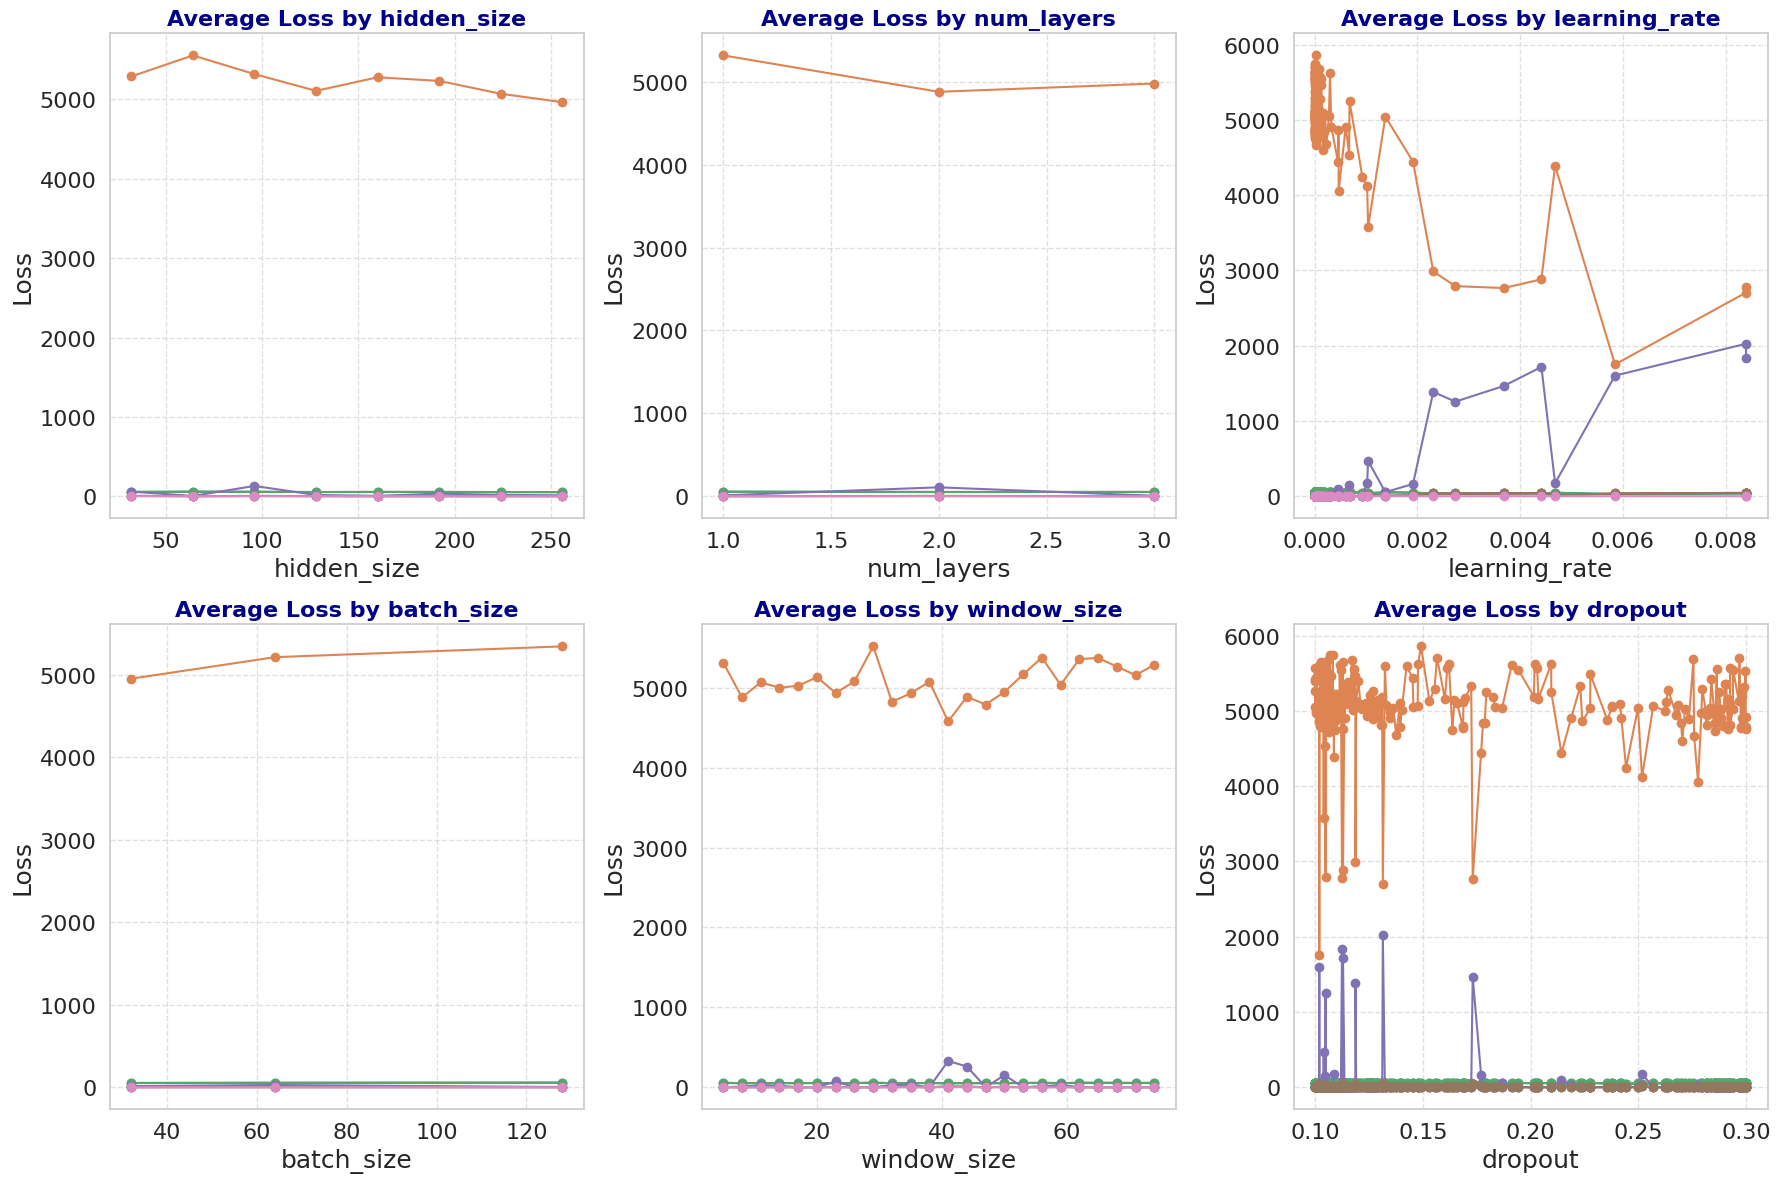

In [14]:
def plot_metrics_by_parameters(metrics_df, parameters, save_path="metrics_by_parameters.png"):
    """
    Create a single figure with subplots for each parameter, showing average losses.

    Args:
        metrics_df (pd.DataFrame): DataFrame containing trial metrics and parameters.
        parameters (list): List of parameters to plot (e.g., ['hidden_size', 'num_layers']).
    """
    # Mapping loss types to more readable names
    loss_type_mapping = {
        "train_HuberLoss": "Train Huber Loss",
        "train_MSE": "Train MSE",
        "train_MAE": "Train MAE",
        "val_HuberLoss": "Validation Huber Loss",
        "val_MSE": "Validation MSE",
        "val_MAE": "Validation MAE",
        "dropout": "Dropout"
    }

    num_params = len(parameters)
    ncols = 3  # Number of columns
    nrows = 2  # Fixed to 2 rows
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 12), sharex=False)

    # Flatten axes for easier iteration
    axes = axes.flatten()

    # Plot each parameter
    for i, (ax, parameter) in enumerate(zip(axes, parameters)):
        grouped = metrics_df.groupby(parameter).mean()  # Group by the parameter and calculate averages
        for loss, readable_name in loss_type_mapping.items():
            if loss in grouped.columns:
                ax.plot(grouped.index, grouped[loss], label=readable_name, marker='o', linestyle='-', linewidth=1.5)

        # Customize each subplot
        ax.set_xlabel(parameter, fontsize=18)
        ax.set_ylabel("Loss", fontsize=18)
        ax.tick_params(axis='both', which='major', labelsize=16)
        ax.set_title(f"Average Loss by {parameter}", fontsize=16, weight='bold', color='darkblue')
        ax.grid(True, linestyle='--', alpha=0.6)

    # Remove unused subplots if parameters < nrows * ncols
    for j in range(len(parameters), len(axes)):
        if j == len(parameters):  # Use the first unused subplot for the legend
            handles, labels = ax.get_legend_handles_labels()
            axes[j].legend(
                handles, labels, loc="center", fontsize=16, title="Loss Type", title_fontsize=20, frameon=False
            )
            axes[j].set_axis_off()  # Turn off the axis for the legend plot
        else:
            fig.delaxes(axes[j])  # Remove any additional unused subplots

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()

# Example: Plot average losses for all parameters in one figure
parameters_to_plot = ["hidden_size", "num_layers", "learning_rate", "batch_size", "window_size", "dropout"]
plot_metrics_by_parameters(all_metrics_df, parameters_to_plot)

### Predict the next 200 data points recursively

<ipython-input-15-a0d0c69097d0>:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  init_window = torch.tensor(val_X[0], dtype=torch.float32).to(device)  # Use the first sequence as the initial window


first 10 predictions: [-0.6906433701515198, -0.7906004786491394, -0.7150524854660034, -0.5452499985694885, -0.37430739402770996, -0.3281155228614807, -0.5171477794647217, -0.8148308396339417, -0.9376826286315918, -0.8555172085762024]


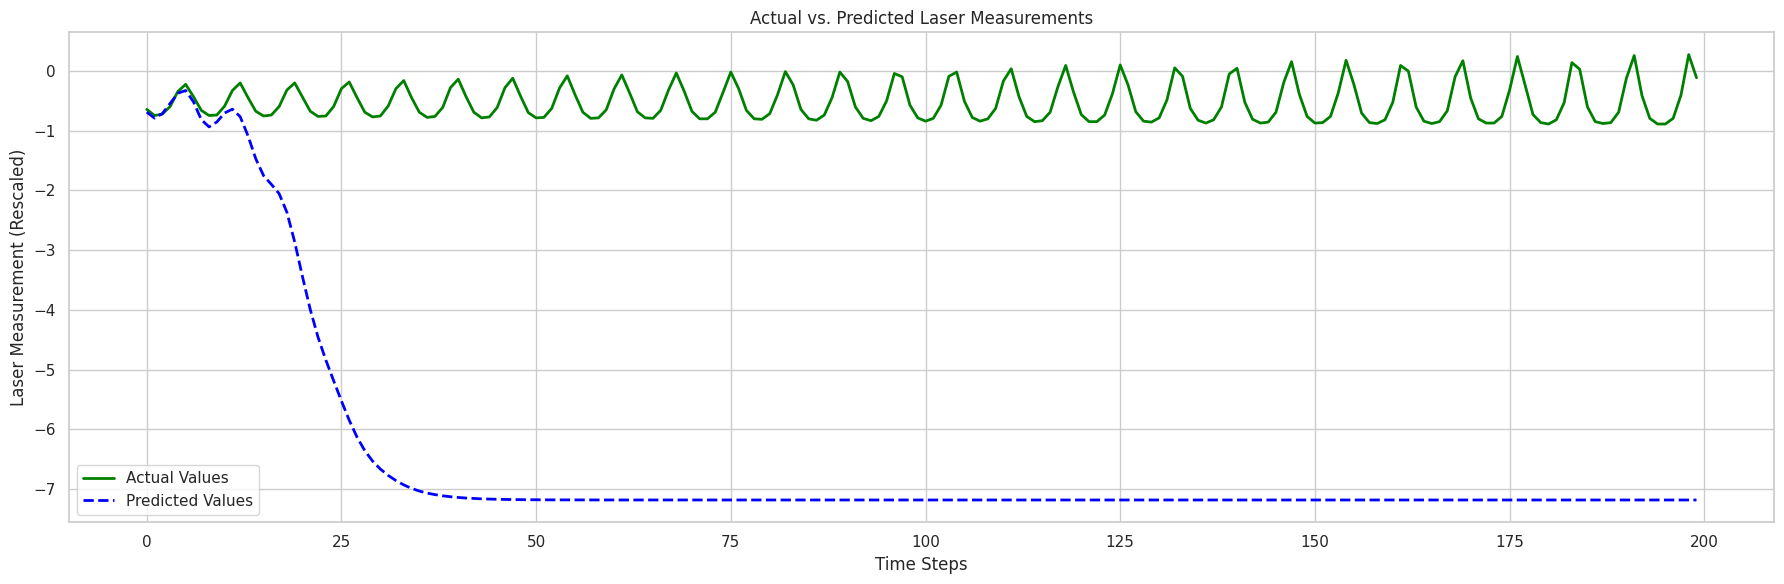

Metrics plot saved to actual_vs_predicted_plot.png


In [15]:
def recursive_forecast(model, init_window, steps=200):
    """
    Perform recursive forecasting using the trained model.

    Args:
        model: The trained Transformer model.
        init_window: The initial sequence window (tensor).
        steps: Number of forecasting steps.
        std: Standard deviation used for normalization.
        mean: Mean used for normalization.

    Returns:
        np.array: Forecasted values rescaled to the original range.
    """
    model.eval()
    preds = []
    current_seq = init_window.clone().to(device)  # Ensure the initial window is on the correct device

    with torch.no_grad():
        for step in range(steps):
            # Forward pass
            input = current_seq.unsqueeze(0).contiguous()  # Add batch dimension
            pred = model(input)  # shape: (1, seq_len, forecast_steps)

            # Extract the first predicted value
            pred_value = pred.item()  # Extract the first step of the forecast
            # Append the prediction
            preds.append(pred_value)

            next_value = torch.tensor([[pred_value]], dtype=torch.float32,  device=device)  # Convert to tensor for concatenation

            # Update the sequence by appending the prediction and removing the oldest value
            current_seq = torch.cat((current_seq[1:], next_value), dim=0)  # Update the sequence
            # # Optional: Clamp predictions to avoid divergence
            # current_seq = torch.clamp(current_seq, min=-3, max=3)  # Adjust range based on normalized data

    print(f"first 10 predictions: {preds[:10]}")
    preds = np.array(preds)
    return preds

def plot_signals(predictions_rescaled, actual_values, save_path="actual_vs_predicted_plot.png"):
    """
    Plot training and validation metrics after training and compare predictions with actual values.
    """
    plt.figure(figsize=(18, 6))

    # Plot Actual vs Predicted Values
    plt.plot(actual_values, label="Actual Values", color="green", linewidth=2)
    plt.plot(predictions_rescaled, label="Predicted Values", color="blue", linestyle="--", linewidth=2)
    plt.xlabel("Time Steps")
    plt.ylabel("Laser Measurement (Rescaled)")
    plt.title("Actual vs. Predicted Laser Measurements")
    plt.legend()

    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()
    print(f"Metrics plot saved to {save_path}")

# Perform recursive forecasting to generate predictions
init_window = torch.tensor(val_X[0], dtype=torch.float32).to(device)  # Use the first sequence as the initial window
predicted_signal = recursive_forecast(best_model, init_window, steps=200)
actual_signal = val_y[:len(predicted_signal)] # Rescale to the original range

plot_signals(predicted_signal, actual_signal)

In [16]:
import torch.nn as nn

def evaluate_model_on_validation(best_model, val_loader):
    """
    Evaluate the best model on the validation dataset and calculate MSE and MAE using PyTorch loss functions.

    Args:
        best_model: The trained model.
        val_loader: The validation dataset (normalized).

    Returns:
        mse: Mean Squared Error.
        mae: Mean Absolute Error.
    """
    # Switch the model to evaluation mode
    best_model.eval()

    # Define PyTorch loss functions
    mse_criterion = nn.MSELoss()
    mae_criterion = nn.L1Loss()

    # Collect predictions and ground truth
    total_mse = 0.0
    total_mae = 0.0
    num_samples = 0

    with torch.no_grad():
        for batch in val_loader:
            x_batch, y_batch = batch[0].to(device), batch[1].to(device)
            output = best_model(x_batch)

            # Calculate losses
            mse = mse_criterion(output, y_batch).item()
            mae = mae_criterion(output, y_batch).item()

            # Accumulate losses
            total_mse += mse * x_batch.size(0)
            total_mae += mae * x_batch.size(0)
            num_samples += x_batch.size(0)

    # Calculate average losses
    avg_mse = total_mse / num_samples
    avg_mae = total_mae / num_samples

    print(f"Validation MSE: {avg_mse}")
    print(f"Validation MAE: {avg_mae}")

    return avg_mse, avg_mae

# Evaluate the best model
mse, mae = evaluate_model_on_validation(best_model, val_loader)

Validation MSE: 0.04514973031834137
Validation MAE: 0.16050225545552152


### Load the trained model

In [17]:
import json

def load_best_model():
    # Load the best hyperparameters
    with open("best_hyperparameters.json", "r") as f:
        best_params = json.load(f)

    # Recreate the model with the best hyperparameters
    best_model = GRU(
        input_size=1,
        hidden_size=best_params["hidden_size"],
        num_stacked_layers=best_params["num_layers"],
        dropout=best_params["dropout"]
    ).to(device)

    # Load the saved model weights
    best_model.load_state_dict(torch.load("best_model.pth"))
    best_model.eval()

    return best_model, best_params

best_model, best_params = load_best_model()
print("Best hyperparameters are:", best_params)

Best hyperparameters are: {'hidden_size': 256, 'num_layers': 3, 'learning_rate': 1.4338161057255659e-05, 'batch_size': 32, 'window_size': 8, 'dropout': 0.28558748369787473}
